### Measure Compactness of Disease Modules

Use eigenvectors to evaluate the compactness of a disease module. Compact modules tend to:

Lie within a narrow range of eigenvector values (e.g., tightly clustered in the spectral space).

Exhibit strong internal connectivity and weak external connectivity.


In [2]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import scipy.sparse as sp
import scipy.stats as st
import math
import community as community_louvain
import urllib.request
import gzip
import obonet
import colorsys
# from colormap import rgb2hex
# from colormap import hex2rgb
import pickle as pk
# from prettytable import PrettyTable
import os.path
import pandas as pd
from collections import defaultdict, Counter, ChainMap
import umap
import scipy.stats as st
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import fcluster
import time
# import statsmodels.sandbox.stats.multicomp as mc
from sklearn.preprocessing import normalize

import plotly.graph_objects as gp
from plotly.offline import init_notebook_mode, iplot
import json

import matplotlib.pyplot as plt
# %matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/V

There is an issue with umap 0.5.3 so use python3.7 instead of python3.10

In [3]:
# import pkg_resources

# # Specify the name of the package you want to check (in this case, "umap-learn")
# package_name = "umap-learn"

# try:
#     # Use pkg_resources to get the version of the package
#     package_version = pkg_resources.get_distribution(package_name).version
#     print(f"The current version of {package_name} is {package_version}")
# except pkg_resources.DistributionNotFound:
#     print(f"{package_name} is not installed.")


## Functions

In [4]:
def rnd_walk_matrix(G, r, a):
    """
    Compute the Random Walk Matrix (RWM) for a given graph G with teleportation probability a
    and damping factor r using the formula (I-r*P)^-1 where P is the Markov matrix.

    Parameters:
    G (networkx graph): The input graph
    r (float): Damping factor
    a (float): Teleportation probability

    Returns:
    W (numpy array): The RWM of the input graph G

    """
    

    n = G.number_of_nodes()                          # get the number of nodes in the graph G
    A = nx.adjacency_matrix(G,sorted(G.nodes()))     # get the adjacency matrix of graph G

    factor = float((1-a)/n)                          # calculate the first scaling term

    E = np.multiply(factor,np.ones([n,n]))           # prepare the second scaling term
    A_tele = np.multiply(a,A) + E                    

    M = normalize(A_tele, norm='l1', axis=0)          # compute the column-wise normalized Markov matrix

    # mixture of Markov chains
    del A_tele
    del E

    U = np.identity(n,dtype=int) 
    H = (1-r)*M
    H1 = np.subtract(U,H)
    del U
    del M
    del H    

    W = r*np.linalg.inv(H1)                          # compute the RWM using the formula (I-r*P)^-1

    return W



def fisher_test(sig_level, sampleset, d_sample_attributes, d_attributes_sample, background):
    """
    Perform a hypergeometric or Fisher's exact test for each feature in a set of samples, 
    using the corresponding attributes in d_sample_attributes and d_attributes_sample.

    Parameters:
    sig_level (float): the significance level of the test.
    sampleset (set): the set of samples to be tested.
    d_sample_attributes (dict): a dictionary with samples as keys and lists of attributes as values.
    d_attributes_sample (dict): a dictionary with attributes as keys and sets of samples as values.
    background (int): the total number of samples in the population.

    Returns:
    d_term_p (dict): a dictionary with attributes as keys and adjusted p-values as values.
    """
    # Make sure that all samples in the sampleset are present in the d_sample_attributes dictionary
    sample_overlap = set(sampleset) & set(d_sample_attributes.keys())

    # Extract all attributes associated with the samples in the sampleset
    
    l_terms = []
    for gene in sample_overlap:
        l_terms.extend(d_sample_attributes[gene])

    # Find the unique set of attributes and the number of tests to be performed
    set_terms = set(l_terms)
    number_of_tests = len(set_terms)



    # Perform the test for each attribute and calculate adjusted p-values
    d_term_p = {}
    for term in set_terms:
        attributeset = set(d_attributes_sample[term])

        ab = len(sample_overlap.intersection(attributeset))
        amb = len(sample_overlap.difference(attributeset))
        bma = len(attributeset.difference(sample_overlap))
        backg = background - ab - amb - bma

        oddsratio, pval = st.fisher_exact([[ab, amb], [bma, backg]],alternative='greater')
        adjusted_pval = pval * number_of_tests

        # Adjust the p-value based on the number of tests performed (Bonferroni)
        if adjusted_pval > sig_level:
            d_term_p[term] = 1.0
        else:
            d_term_p[term] = adjusted_pval

    return d_term_p


##################################################################
##################################################################

def color_creator(n):

    colors = [colorsys.hsv_to_rgb(1.0/n*x,1,1) for x in range(n)]
    color_list = []
    for c in colors:
        cc = [int(y*255) for y in c]
        color_list.append('#%02x%02x%02x' % (cc[0],cc[1],cc[2]))
        
    return color_list


def generate_colors(n):
    # Generate equally spaced Hue values
    hues = [i/n for i in range(n)]
    
    # Set Saturation and Lightness to fixed values
    saturation = 0.5
    lightness = 0.5
    
    # Convert HSL colors to RGB colors and then to hex colors
    rgb_colors = [colorsys.hls_to_rgb(hue, lightness, saturation) for hue in hues]
    hex_colors = [f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}" for r, g, b in rgb_colors]
    
    return hex_colors


# def fibonacci_sphere(n, center=(0, 0, 0), radius=1):
#     """
#     Generate n points evenly distributed on the surface of a sphere.
#     Allows control over the center point and radius of the sphere.
#     """
#     points = []
#     offset = 2 / n
#     increment = np.pi * (3 - np.sqrt(5))

#     for i in range(n):
#         y = ((i * offset) - 1) + (offset / 2)
#         r = np.sqrt(1 - y**2)
#         phi = ((i + 1) % n) * increment
#         x = np.cos(phi) * r
#         z = np.sin(phi) * r
#         points.append([x, y, z])

#     points = np.array(points)
#     points = points - np.min(points, axis=0)
#     points = points / np.max(points, axis=0)
    
#     # Scale and translate the points based on the radius and center
#     points = points * radius + np.array(center)
    
#     return points


def fibonacci_sphere(n, center=(0, 0, 0), radius=1.0):
    """
    Generate n points evenly distributed on the surface of a sphere.
    Allows control over the center point and radius of the sphere.
    """
    points = np.zeros((n, 3))
    offset = 2 / n
    increment = np.pi * (3 - np.sqrt(5))

    for i in range(n):
        y = ((i * offset) - 1) + (offset / 2)
        r = np.sqrt(1 - y**2)
        phi = ((i + 1) % n) * increment
        x = np.cos(phi) * r
        z = np.sin(phi) * r
        points[i] = [x, y, z]

    # Scale and translate the points based on the radius and center
    points = points * radius + np.array(center)
    
    return points

def eigenlayout(G, dim=3, n_lam=18, n_neighs=10, spread=1.0):
    """
    Compute the UMAP layout of a graph based on its normalized Laplacian matrix.

    Parameters:
    -----------
    G : NetworkX graph object
        The input graph.
    dim : int, optional (default=3)
        The number of dimensions in the UMAP projection.
    n_lam : int, optional (default=18)
        The number of eigenvalues and eigenvectors to use in the spectral dimensionality reduction.
    n_neighs : int, optional (default=10)
        The number of nearest neighbors to use in the UMAP algorithm.
    spread : float, optional (default=1.0)
        The spread of the UMAP projection.

    Returns:
    --------
    d_umap_pos : dictionary with graph nodes as keys and aray - shape: (n_nodes, dim) as values
        The UMAP projection of the graph nodes as a numpy array.
    """
    if n_lam > G.number_of_nodes()-1:
        print('The number of Eigenvectors must be smaller than the number of nodes - 1!')
        print('Please provide a smaller number. (Not more than 0.1xnumber_of_nodes recommended)')

    # Compute the normalized Laplacian matrix
    M_laplace = nx.normalized_laplacian_matrix(G, sorted(G.nodes()))

    # Construct the matrix M_ImL = I - L where L is the normalized Laplacian matrix and I is the identity matrix
    n_nodes = G.number_of_nodes()
    Id = sp.identity(n_nodes)
    M_ImL = Id - M_laplace

    # Compute the n_lam smallest eigenvalues and eigenvectors of M_ImL
    # M_V: #rows = #nodes and #cols = #eigenvls 
    Lam,M_V = sp.linalg.eigsh(M_ImL,k=n_lam)

    # FEATURE VECTOR
    # re-sort M_V by desc Lam - 1st column: eigenvec for largest Eigenvalue ...
    N = n_lam

    rev_ordered_idx = np.argsort(Lam)
    # spectral dimensional reduction:
    f_vec_1 = [x.real for x in M_V[:,rev_ordered_idx[-1]]]
    arr = f_vec_1

    for m in range(2,N+1):
        f_vec_2 = [x.real for x in M_V[:,rev_ordered_idx[-m]]]
        arr = np.vstack((arr,f_vec_2))

    # # UMAP
    FX = arr.transpose()

    mind = .2
    reducer = umap.UMAP(n_components=dim,n_neighbors=n_neighs, metric = 'cosine', min_dist=mind, spread = spread)
    umap_pos = reducer.fit_transform(FX)


    d_node_pos = {}

    for i, node in enumerate(sorted(G.nodes())):
        d_node_pos[node] = umap_pos[i,:]


    return d_node_pos



def plotly_preview(G, Gpos, node_colors=None, edge_colors=None, links=True, subset_smaller_nodes=[], hoverlabels = None):
    """
    Generate a 3D network visualization using Plotly.

    Parameters:
        - G (networkx.Graph): The graph object representing the network.
        - Gpos (dict): A dictionary mapping each node to its 3D coordinates (x, y, z).
        - node_colors (dict, optional): A dictionary mapping nodes to custom hex colors.
                                        If not provided, the default color is '#40b9d4'.
        - edge_colors (dict, optional): A dictionary mapping edges to custom hex colors.
                                        If not provided, the default color is 'gray'.
        - links (bool, optional): If True, show edges between nodes. Default is True.
        - subset_smaller_nodes (list, optional): A list of nodes to be shown with smaller markers.
        - d_sym_clusterlabel (dict, optional): A dictionary mapping nodes to labels for hover text.

    Output:
        - An HTML file named 'network_preview.html' is generated, which opens in a web browser.

    Example usage:
        node_colors = {1: '#ff0000', 2: '#00ff00', 3: '#0000ff'}
        edge_colors = {(1, 2): '#ff00ff', (2, 3): '#ffff00'}
        pos = nx.spring_layout(G, dim=3)
        plotly_preview(G, pos, node_colors, edge_colors)
    """

    # Extract x, y, z coordinates from the positions dictionary
    x_coords = [pos[0] for pos in Gpos.values()]
    y_coords = [pos[1] for pos in Gpos.values()]
    z_coords = [pos[2] for pos in Gpos.values()]
    node_labels = list(Gpos.keys())

    # Get node colors and sizes
    colors = [node_colors[node] if node_colors and node in node_colors else '#40b9d4' for node in node_labels]
    node_size = [2 if node in subset_smaller_nodes else 8 for node in node_labels]

    # Get hover text labels
    hover_text = [hoverlabels[node] if hoverlabels and node in hoverlabels else '' for node in node_labels]

    # Create a 3D scatter plot for node positions
    scatter_plot = gp.Scatter3d(
        x=x_coords,
        y=y_coords,
        z=z_coords,
        mode='markers',
        text=hover_text,
        hovertemplate='%{text}<extra></extra>',  # remove coordinates from hover text
        marker=dict(
            size=node_size,
            color=colors,
            opacity=1.
        )
    )

    # Set up the layout with all axes and labels removed
    layout = gp.Layout(
        scene=dict(
            xaxis=dict(
                visible=False
            ),
            yaxis=dict(
                visible=False
            ),
            zaxis=dict(
                visible=False
            )
        ),
        title='3D preview'
    )

    # Create and save the plot as an HTML file
    fig = gp.Figure(data=[scatter_plot], layout=layout)
    fig.write_html('network_preview.html', auto_open=False)




def make_json(name, network, positions, node_color = '#40b9d4', link_color = '#999999', annotations = 'None', communities = 'None'):
    """
    Generates a JSON file from a given network graph using the specified parameters.

    Args:
        name (str, optional): Name of the graph.
        network (networkx.Graph): Network graph object.
        positions (dict): Dictionary mapping node IDs to their positions.
        node_color (dict): Dictionary mapping node IDs to their (hex-)colors.
        link_color (str or dict): (Hex-)color value for all links in the graph or dict with node tuple as key and hex color as value.
        communities (dict): 'None' for no communities (default) or dictionary mapping node IDs to their corresponding community ID.
        annotations (dict): Dictionary mapping node IDs to a list of annotations.

    Returns:
        None

    """

    # --------------------------
    # Generate VR GRAPH
    # --------------------------
    GVR = nx.Graph()
    GVR.graph['name'] = name

    # --------------------------------------
    # LOOKUP FOR NODE NAMES INTO IDs and vv
    # --------------------------------------
    d_idx_node = {}
    d_node_idx = {}
    for i, node in enumerate(sorted(network.nodes())):
        d_idx_node[i] = node
        d_node_idx[node] = i
    GVR.add_nodes_from(d_idx_node.keys())

    for edge in network.edges()(data=True):
        GVR.add_edge(d_node_idx[edge[0]],d_node_idx[edge[1]])

    # --------------------------
    # POS
    # --------------------------
    if isinstance(positions[next(iter(positions))], list):
        pass
    else:
        for key in positions:
            positions[key] = positions[key].tolist()

    posG = {d_node_idx[node]: list(xyz) for node, xyz in positions.items()}
    nx.set_node_attributes(GVR, posG, name="pos")

    # # --------------------------
    # # CLUSTER
    # # --------------------------
    if communities == 'None':
        d_VRids_cluster = dict(zip(d_idx_node.keys(), [0 for _ in d_idx_node.keys()]))
    else:
        d_VRids_cluster = {d_node_idx[node]: str(cl_id) for node, cl_id in communities.items()}
    nx.set_node_attributes(GVR, d_VRids_cluster, name="cluster")


    # --------------------------
    # NODE COLOR
    # --------------------------
    d_node_colors={}

    if isinstance(node_color, dict):
        for nodeid in GVR.nodes():
            d_node_colors[nodeid] = node_color[d_idx_node[nodeid]]
    else:
        for nodeid in GVR.nodes():
            d_node_colors[nodeid] = node_color

    nx.set_node_attributes(GVR, d_node_colors, name="nodecolor")

    # --------------------------
    # LINK COLOR
    # --------------------------
    if isinstance(link_color, dict):
        # for different link colors
        d_edge_color = {}
        for a,b in GVR.edges():
            try:
                color = link_color[(d_idx_node[a],d_idx_node[b])]
            except KeyError:
                color = link_color[(d_idx_node[b],d_idx_node[a])]
            d_edge_color[(a,b)] = color
    else:
        # for unique link colors
        d_edge_color = {}
        for a,b in GVR.edges():
            d_edge_color[(a,b)] = link_color

    nx.set_edge_attributes(GVR, d_edge_color, name="linkcolor")

    # --------------------------
    # NODE ANNOTATION
    # --------------------------
    if isinstance(annotations, dict):

        l_annotations = [[str(d_idx_node[nodeid])] + [ annotation for annotation in annotations[d_idx_node[nodeid]]] for nodeid in sorted(GVR.nodes())]
        d_annotations = dict(zip(sorted(GVR.nodes()), l_annotations))
    else:
        d_annotations = {nodeid: [str(d_idx_node[nodeid])] for nodeid in GVR.nodes()}

    nx.set_node_attributes(GVR, d_annotations, name="annotation")

    # --------------------------
    # MAKE JSON fo uploader
    # --------------------------

    G_json = json.dumps(nx.node_link_data(GVR))

    with open(GVR.name+".json", "w") as outfile:
        outfile.write(G_json)



def Ginfo(G):
    info = []
    info.append(f"Graph Name: {G.name}")
    info.append(f"Graph Type: {type(G).__name__}")
    info.append(f"Number of Nodes: {G.number_of_nodes()}")
    info.append(f"Number of Edges: {G.number_of_edges()}")
    # info.append(f"Density: {round(100. * nx.density(G), 3)} %")

    # if nx.is_weighted(G):
    #     info.append(f"Weighted: Yes")
        
    #     # Calculate the average degree considering edge weights for weighted graphs
    #     avg_weighted_degree = sum(weight for u, v, weight in G.edges(data=True)) / G.number_of_nodes()
    #     info.append(f"Average Weighted Degree: {round(avg_weighted_degree, 2)}")
    # else:
    #     info.append(f"Weighted: No")
        
    #     # Calculate the average degree as usual for unweighted graphs
    #     avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
    #     info.append(f"Average Degree: {round(avg_degree, 2)}")

    info.append(f"Connected: {'Yes' if nx.is_connected(G) else 'No'}")
    num_components = nx.number_connected_components(G)
    info.append(f"Number of Connected Components: {num_components}")

    info.append(f"Directed: {'Yes' if G.is_directed() else 'No'}")
    
    return "\n".join(info)



In [5]:


def download_mapping_file(url, filename):
    urllib.request.urlretrieve(url, filename)

def parse_mapping_file(filename):
    mapping = {}
    with gzip.open(filename, 'rt') as file:
        for line in file:
            if line.startswith('#'):  # Skip header and comments
                continue
            fields = line.strip().split('\t')
            if fields[0] == '9606':
                gene_symbol = fields[2]
                entrez_id = fields[1]
                ensembl_id = fields[5]
                # Additional mapping field
                gene_name = fields[11]
                if gene_symbol not in mapping:
                    mapping[gene_symbol] = {
                        'entrez_id': entrez_id,
                        'ensembl_id': ensembl_id,
                        'gene_name': gene_name
                    }
    return mapping


def convert_symbols_to_entrez(gene_symbols, mapping):
    entrez_ids = []
    for symbol in gene_symbols:
        if symbol in mapping:
            entrez_ids.append(mapping[symbol]['entrez_id'])
    return entrez_ids

def convert_symbols_to_ensembl(gene_symbols, mapping):
    ensembl_ids = []
    for symbol in gene_symbols:
        if symbol in mapping:
            ensembl_ids.append(mapping[symbol]['ensembl_id'])
    return ensembl_ids

# Download Gene Info file (example using Homo sapiens)
url = 'ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/GENE_INFO/Mammalia/Homo_sapiens.gene_info.gz'
filename = 'Homo_sapiens.gene_info.gz'
download_mapping_file(url, filename)

# Parse mapping file
mapping = parse_mapping_file(filename)

# Generate a dictionary of all existing gene symbols and their corresponding Entrez IDs and Ensemble IDs
all_gene_symbols = list(mapping.keys())
all_entrez_ids = [mapping[symbol]['entrez_id'] for symbol in all_gene_symbols]
all_ensembl_ids = [mapping[symbol]['ensembl_id'] for symbol in all_gene_symbols]
symbol_to_entrez = dict(zip(all_gene_symbols, all_entrez_ids))
symbol_to_ensembl = dict(zip(all_gene_symbols, all_ensembl_ids))
entrez_to_symbols = {v: k for k, v in symbol_to_entrez.items()}
ensembl_to_symbols = {v: k for k, v in symbol_to_ensembl.items()}


### load PPI

In [6]:
def Ginfo(G):
    info = []
    info.append(f"Graph Name: {G.name}")
    info.append(f"Graph Type: {type(G).__name__}")
    info.append(f"Number of Nodes: {G.number_of_nodes()}")
    info.append(f"Number of Edges: {G.number_of_edges()}")
    info.append(f"Density: {round(100.*nx.density(G),3)} %")
    info.append(f"Average Degree: {round(sum(dict(G.degree()).values()) / G.number_of_nodes(),2)}")
    info.append(f"Connected: {'Yes' if nx.is_connected(G) else 'No'}")
    num_components = nx.number_connected_components(G)
    info.append(f"Number of Connected Components: {num_components}")
   
    info.append(f"Directed: {'Yes' if G.is_directed() else 'No'}")
    return "\n".join(info)
    return info

In [7]:

# PPI direct
path = '/Users/fmueller/work/NICE/GitNICE/Data/'
G_ppi = nx.read_edgelist(path + 'PPIs/PPI_physical_elist.csv',data=False, delimiter=',')
print(Ginfo(G_ppi))
print('\n')

lcc = max(nx.connected_components(G_ppi), key=len)
G = nx.subgraph(G_ppi,lcc)

print(Ginfo(G))

Graph Name: 
Graph Type: Graph
Number of Nodes: 18068
Number of Edges: 306914
Density: 0.188 %
Average Degree: 33.97
Connected: No
Number of Connected Components: 2
Directed: No


Graph Name: 
Graph Type: Graph
Number of Nodes: 18064
Number of Edges: 306911
Density: 0.188 %
Average Degree: 33.98
Connected: Yes
Number of Connected Components: 1
Directed: No


### execute random walk

takes ca 5 min

In [8]:
# r = .8
# alpha = 1.

# W = rnd_walk_matrix(G, r, alpha)

# print('Inversion done')

# d_idx_entz = {}
# cc = 0
# for entz in sorted(G.nodes()):
#     d_idx_entz[cc] = entz
#     cc += 1
# d_entz_idx = dict((y,x) for x,y in d_idx_entz.items())   


### iterate through RW operator and write neighborhood file

takes ca 5 minutes

In [9]:
# ########################################################################
# #
# #    CREATE NEIGHBORHOOD DICTIONARY TO CHECK 
# #    FOR AMBIGUITY OF NEIGHBORS
# #
# ###################

# t0 = time.time()

# coverage = .95
# d_node_neighbors = {}
# for node in sorted(G.nodes()):
#     node_idx = d_entz_idx[node]   

#     p_vis_vector = np.array(W_c[:, node_idx]).flatten()  # Flatten the array to 1D
#     indices = np.argsort(p_vis_vector)[::-1]  # This sorts in descending order

#     p_cum = 0
#     l_neighnodes = []
#     for idx in indices:
#         pvis = p_vis_vector[idx]
#         p_cum += pvis
#         if p_cum < coverage:
#             l_neighnodes.append(int(d_idx_entz[idx]))
#         else:
#             break

#     d_node_neighbors[node] = l_neighnodes

# print('time to generate neighborhood file: %.2f' %float(time.time()-t0))

In [10]:

# Pickle the object
# with open('d_node_neighbors07.pkl', 'wb') as file:
#     pk.dump(d_node_neighbors, file)

# # Load the pickled object
# with open(path + 'Neighborhoods/d_node_neighbors085.pkl', 'rb') as file:
#     d_node_neighbors = pk.load(file)



### load annotation data 

Here: disease associations

In [ ]:
# path = '/Users/fmueller/work/NICE/GitNICE/Data/'

d_attributes_sample = pk.load( open(path + "DO/d_doup_genes.pkl", "rb" ) )
d_sample_attributes = pk.load( open(path + "DO/d_gene_doup.pkl", "rb" ) )

d_attributes_plainsample = pk.load( open(path + "DO/d_doup_genes.pkl", "rb" ) )
d_plainsample_attributes = pk.load( open(path + "DO/d_gene_doup.pkl", "rb" ) )

d_term_name =  pk.load( open(path + "DO/DO_names.pkl", "rb" ) )


In [20]:
# Compute the normalized Laplacian matrix
M_laplace = nx.normalized_laplacian_matrix(G, sorted(G.nodes()))



# Compute the n_lam largest eigenvalues and eigenvectors of M_ImL

n_lam = 1000
Lam,M_V = sp.linalg.eigsh(M_laplace,k=n_lam, which='SM')





In [14]:
# reduce list of disease names to 
# those that comes with a disease association

d_term_dnamewithgenes = {}
for term, dname in d_term_name.items():
    try:
        a = d_attributes_sample[term]
        d_term_dnamewithgenes[term] = dname
    except:
        pass

print('# total diseases: ', len(d_term_name.keys()))
print('# gene diseases: ', len(d_term_dnamewithgenes.keys()))


# total diseases:  10897
# gene diseases:  3911


In [17]:
random_disease = rd.choice(list(d_term_dnamewithgenes.keys()))
print(d_term_dnamewithgenes[random_disease])

disease_genes = d_attributes_sample[random_disease]

choroidal sclerosis


In [32]:
approx_name = 'colon carcinoma'

for k, v in d_term_dnamewithgenes.items():
    if v.find(approx_name) != -1:
        print(k,v)

selected_disease = k
disease_genes = d_attributes_sample[selected_disease]

DOID:1520 colon carcinoma


In [33]:
# Compute contributions of disease genes to eigenvectors
def describe_disease(disease_genes, nodes, eigenvectors, eigenvalues):
    # Map disease genes to node indices
    node_indices = [nodes.index(gene) for gene in disease_genes if gene in nodes]
    
    # Extract rows corresponding to disease genes
    disease_contributions = eigenvectors[node_indices, :]
    
    # Summarize contributions for each eigenvector
    mean_contributions = disease_contributions.mean(axis=0)
    
    # Link to eigenvalues
    eigenvalue_contribution = {eigenvalues[i]: mean_contributions[i] for i in range(len(eigenvalues))}
    
    return eigenvalue_contribution

# Describe a disease
print(disease_genes)

eigenvalue_contributions = describe_disease(disease_genes, sorted(G.nodes()), M_V, Lam)

# # Print the contributions
# print("Eigenvalue contributions for Disease X:")
# for eigval, contrib in eigenvalue_contributions.items():
#     print(f"Eigenvalue {eigval:.4f}: Contribution {contrib:.4f}")



['2688', '2936', '2719', '4726', '4729', '25915', '2693', '55163', '5091', '5449', '4720', '50937', '2239', '3030', '2109', '10128', '6833', '7385', '25821', '3643', '55699', '9150', '5122', '5015', '5095', '5528', '5626', '6648', '2736', '1738', '4715', '36', '2592', '29078', '3158', '4724', '2690', '3265', '6927', '4709', '3553', '1716', '23417', '3172', '1629', '178', '4722', '2108', '7124', '3481', '594', '1374', '229', '5261', '2184', '3028', '5265', '23530', '2710', '4694', '4221', '5105', '5106', '3630', '5096', '2538', '4351', '28976', '2203', '2908', '10297', '3767', '23432', '2542', '7381', '29072', '2110', '8820', '8802', '4719', '2639', '5836', '617', '5256', '2998', '3155', '763', '54941', '4723', '55572', '6658', '788', '5009', '4358', '775', '5728', '51103', '593', '34', '9095', '51660', '5465']


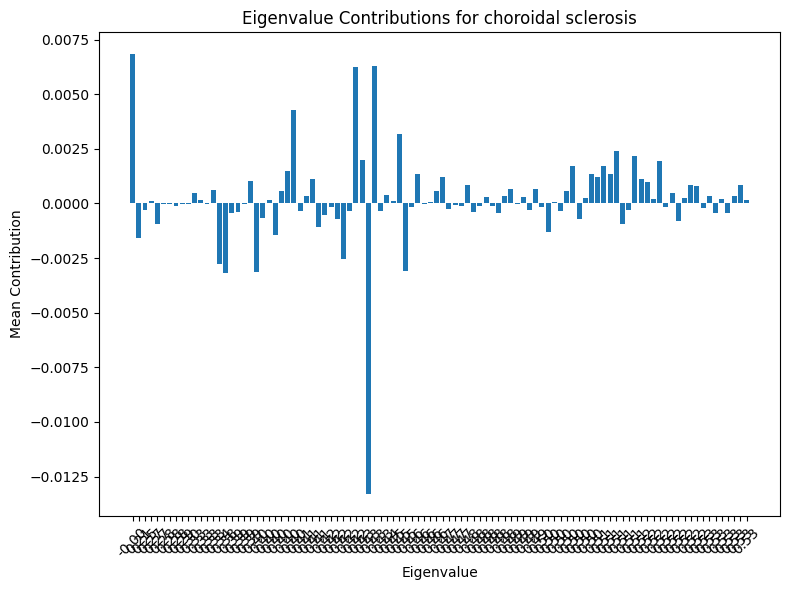

In [ ]:
disease_name = d_term_dnamewithgenes[selected_disease]
number_of_eigenvals2plot = 100
# Sort contributions by eigenvalue
sorted_eigenvalues = sorted(eigenvalue_contributions.keys())
contributions = [eigenvalue_contributions[ev] for ev in sorted_eigenvalues]

# Plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(sorted_eigenvalues))[:number_of_eigenvals2plot], 
        contributions[:number_of_eigenvals2plot], 
        tick_label=[f"{ev:.2f}" for ev in sorted_eigenvalues[:number_of_eigenvals2plot]])
plt.xlabel("Eigenvalue")
plt.ylabel("Mean Contribution")
plt.title(f"Eigenvalue Contributions for {disease_name}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
# import networkx as nx
# import scipy.sparse.linalg as sp
# import numpy as np
from scipy.spatial.distance import cosine, euclidean



# Project disease genes into the eigenspace
sorted_nodes = sorted(G.nodes())
def project_disease(disease_genes, nodes, eigenvectors):
    # Map disease genes to node indices
    node_indices = [nodes.index(gene) for gene in disease_genes if gene in nodes]
    print(node_indices)
    # Extract rows corresponding to disease genes
    disease_projection = eigenvectors[node_indices, :]
    # Compute mean projection
    return disease_projection.mean(axis=0)

# Get mean projections for diseases
mean_X = project_disease(d_attributes_sample['DOID:11054'], sorted_nodes, M_V)
mean_Y = project_disease(d_attributes_sample['DOID:0050686'], sorted_nodes, M_V)

# Compare diseases
cosine_similarity = 1 - cosine(mean_X, mean_Y)
euclidean_distance = euclidean(mean_X, mean_Y)

print(f"Cosine similarity: {cosine_similarity}")
print(f"Euclidean distance: {euclidean_distance}")


[8104, 8921, 8756, 5907, 12398, 864, 5630, 485, 17731, 3242, 6477, 13872, 3932, 1048, 16295, 3855, 3913, 854, 1, 9204, 3448, 7417, 15308, 15858, 11573, 13575, 3918, 7382, 17675, 7935, 17844, 2460, 5826, 8909, 13866, 7464, 10206, 7060, 570, 11945, 14261, 15064, 13891, 2818, 7574, 9062, 13974, 9398, 7491, 3832, 15532, 10100, 3624, 8169, 7486, 6543, 7582, 14314, 8712, 12310, 3578, 4243, 2546, 10283, 7089, 1229, 3911, 4003, 8257, 17785, 8373, 13634, 11951, 11668, 7599, 7967, 4249, 6032, 15533, 630, 3929, 8907, 8556, 10926, 5768, 15333, 6644, 16801, 16849, 8963, 16682, 6639, 7045, 3993, 17697, 13477, 7623, 14002, 14562, 6647, 15516, 1710, 7011, 7968, 9816, 2363, 9691, 18057, 14255, 15852, 441, 3083, 14283, 15538, 11901, 7686, 15501, 10348, 2635, 14524]
[2538, 11905, 5503, 9821, 7103, 8402, 13935, 4682, 10199, 3879, 1420, 4770, 8619, 8765, 226, 12108, 3288, 7699, 626, 3184, 9619, 4808, 9610, 13618, 5054, 15308, 15328, 6596, 5098, 15212, 8246, 14335, 7051, 6036, 6129, 7382, 12272, 11632, 8239

In [8]:
d_attributes_sample.keys()

dict_keys(['DOID:11054', 'DOID:3996', 'DOID:0050686', 'DOID:162', 'DOID:14566', 'DOID:4', 'DOID:615', 'DOID:9500', 'DOID:74', 'DOID:7', 'DOID:3571', 'DOID:3119', 'DOID:2773', 'DOID:2723', 'DOID:37', 'DOID:16', 'DOID:4404', 'DOID:10283', 'DOID:3856', 'DOID:193', 'DOID:10286', 'DOID:1790', 'DOID:0050687', 'DOID:2645', 'DOID:0060084', 'DOID:0060072', 'DOID:1612', 'DOID:5093', 'DOID:3393', 'DOID:0050828', 'DOID:178', 'DOID:1287', 'DOID:9952', 'DOID:1037', 'DOID:1240', 'DOID:2531', 'DOID:0060083', 'DOID:987', 'DOID:4535', 'DOID:421', 'DOID:1098', 'DOID:11252', 'DOID:2355', 'DOID:718', 'DOID:0060050', 'DOID:417', 'DOID:0060056', 'DOID:2914', 'DOID:2841', 'DOID:1176', 'DOID:0050161', 'DOID:1579', 'DOID:9360', 'DOID:9415', 'DOID:12849', 'DOID:0060041', 'DOID:0060040', 'DOID:0060037', 'DOID:150', 'DOID:6000', 'DOID:114', 'DOID:999', 'DOID:3683', 'DOID:0050621', 'DOID:0060085', 'DOID:614', 'DOID:1352', 'DOID:2825', 'DOID:974', 'DOID:2163', 'DOID:552', 'DOID:850', 'DOID:0050127', 'DOID:319', 'DOI

### enrichment of every single gene-neighborhood

takes 20' for F

In [11]:
# t0 = time.time()

# sig_level = .05

# # select disease genes as background only 
# background = len(d_sample_attributes.keys())

# c = 0
# d_gene_enr_terms = {} 

# for gene in d_node_neighbors.keys():
#     # print(gene)
# #     if c<10:
#     c += 1
#     sampleset = [str(x) for x in set(d_node_neighbors[gene])]

#     # print(sampleset)
#     d_dis_p = fisher_test(sig_level,sampleset,d_sample_attributes,d_attributes_sample,background)
#     # fdis.write('GENE: %s|' %k)  
# #         print('GENE %s' %k)
# #     for x in sorted(d_dis_p.items(), key = lambda x: x[1]):
#     l_dis = []
#     for x,p in d_dis_p.items():
#         if (p < sig_level):
#             l_dis.append(x)

#             # fdis.write(str(x) +',' + str(round(p,4)) + '|')
#     # fdis.write('\n')
#     d_gene_enr_terms[gene] = l_dis

# print('time to generate enrichment dict: %.2f' %float(time.time()-t0))

In [7]:
# Pickle the object
# with open('d_gene_enr_disONphysPPIr085.pkl', 'wb') as file:
#     pk.dump(d_gene_enr_terms, file)

# Load the pickled object
with open(path + 'Enriched/d_gene_enr_disONphysPPIr085.pkl', 'rb') as file:
    d_gene_enr_terms = pk.load(file)



### -----------------

In [13]:
# pk.dump( d_node_neighbors, open( "Neigborhdata/neigbrhd_r=%s.pkl" %r, "wb" ) )

### load ontology tree


In [8]:
# downwards directed tree

DO_downtree = pk.load( open( path + 'DO/G_DO_down.pkl', 'rb' ) )
DO_tip = pk.load( open( path + 'DO/DO_tip.pkl', 'rb' ) )

# Make dict that connects subvolumes to any term in DO
d_do_subvol = {}
c = 0
for do in DO_downtree.nodes():
    des_vol = len(nx.descendants(DO_downtree,do))+1
    d_do_subvol[do] = len(nx.descendants(DO_downtree,do))+1

add also to the added enriched terms all upstreams

In [9]:
# and the upstream dict 
d_gene_enr_up = {}
c = 0 
for gene, l_enrterms in d_gene_enr_terms.items():
    l_up = []
    for engo in l_enrterms:
        if engo in DO_downtree:
            for up in nx.ancestors(DO_downtree,engo):
                l_up.append(up)
            l_up.append(engo)
    d_gene_enr_up[gene] =  set(l_up)
    c += 1


### combine plain and enriched

In [10]:
# ADD ENRICHED TERMS TO PLAIN  

###################
#
#  if no enrichment is going on 
#
###################


d_gene_terms_all = {}
c = 0
cc = 0

for gene in G.nodes():
    # gene = int(gene)
    try:
        l_enr = d_gene_enr_up[gene]
        c += 1
    except KeyError:
        l_enr = []    
    
    try:
        l_pure = d_sample_attributes[gene]
        cc += 1
    except KeyError:
        l_pure = []
        
        
    s_all = set(list(l_enr)+list(l_pure))
    # for shice:
#     s_all = list(l_pure)

    if len(s_all) > 0:
        d_gene_terms_all[gene] = s_all
    # d_gene_terms_all[gene] = s_all

print(c)


18064


### sample overview

In [12]:
c = 0
print('gene, #pure terms, #enriched+pure terms, factor')
for gene, terms in d_sample_attributes.items():
    all = len(d_gene_terms_all[gene])
    factor = 1.*all/len(terms)
    print(entrez_to_symbols[gene], len(terms), all, factor)
    c += 1
    if c > 20:
        break

gene, #pure terms, #enriched+pure terms, factor
ANXA2R 6 6 1.0
MTHFR 223 223 1.0
MPO 94 94 1.0
SMC1B 6 6 1.0
RB1 125 174 1.392
STAG2 19 19 1.0
FBXW8 6 6 1.0
CDKN2A 162 192 1.1851851851851851
RALGPS1 6 6 1.0
DCC 45 45 1.0
GPX1 134 134 1.0
TERT 195 219 1.123076923076923
ESR2 101 101 1.0
FERMT2 15 15 1.0
IGSF21 6 6 1.0
EP300 213 258 1.2112676056338028
AKT1 282 381 1.351063829787234
SLC12A7 6 6 1.0
NAT2 37 47 1.2702702702702702
NRAS 247 259 1.048582995951417
NQO1 95 113 1.1894736842105262


### generate lookup tables

d_gene_idx_feat assigns index to genes sorted numerically by entrezID

In [13]:
d_gene_idx_feat = {}
d_idx_gene_feat = {}
nn = 0      
        
# all terms
l_terms = []

for gene, l_t in sorted(d_gene_terms_all.items()):
    l_terms += l_t 
    d_gene_idx_feat[gene] = nn
    d_idx_gene_feat[nn] = gene
    nn += 1   
    
s_terms = set(l_terms)

# sort terms by specificity

sorted_s_terms = sorted(s_terms, key=lambda x: d_do_subvol.get(x, 0), reverse=True)

make venn diagrams to count the number of anntotated and newly annotated genes

In [14]:
from matplotlib_venn import venn2
def plot_venn_diagram(set1, set2, set1_name = 'set 1',set2_name = 'set 2'):
    # Create the Venn diagram
    venn = venn2([set1, set2], set_labels=(set1_name, set2_name))

    # Customize the Venn diagram colors
    venn.get_patch_by_id('10').set_color('#aaaaaa')
    venn.get_patch_by_id('01').set_color('lightgreen')
    venn.get_patch_by_id('11').set_color('purple')

    # Add labels to the individual set regions
    set1_label = venn.get_label_by_id('10')
    set2_label = venn.get_label_by_id('01')
    overlap_label = venn.get_label_by_id('11')

    set1_label.set_text(len(set1 - set2))
    set2_label.set_text(len(set2 - set1))
    overlap_label.set_text(len(set1 & set2))


    # Set text color for the labels
    set1_label.set_color('white')
    set2_label.set_color('white')
    overlap_label.set_color('white')

    set1_label.set_fontsize(16)
    set2_label.set_fontsize(16)
    overlap_label.set_fontsize(16)

    i = 0
    for text in venn.set_labels:
        text.set_color('gray')
        text.set_fontsize(20)
    i+=1
    

    # Display the Venn diagram
    plt.show()

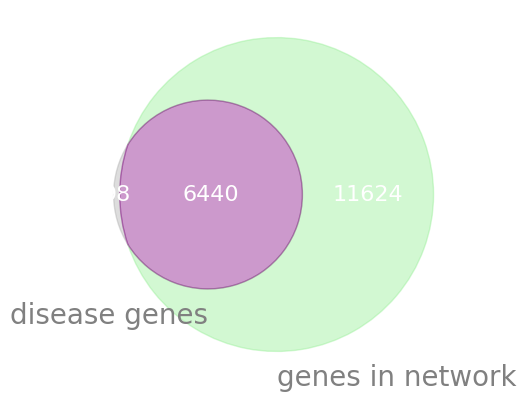

In [15]:

plot_venn_diagram(set(d_sample_attributes.keys()),set(G.nodes()),set1_name='disease genes',set2_name='genes in network')

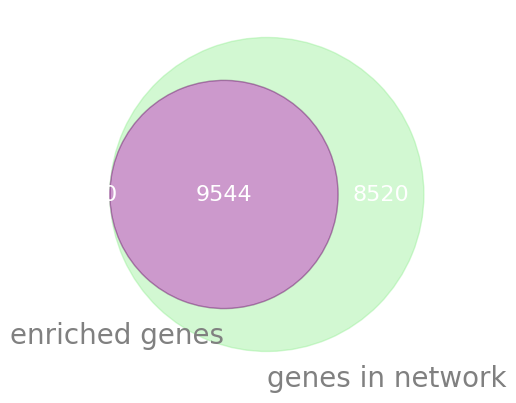

In [16]:
plot_venn_diagram(set(d_gene_terms_all.keys()),set(G.nodes()),set1_name='enriched genes',set2_name='genes in network')

### generate FEATURE MATRIX

`feature_indices` is the dict of GO-terms and their coumn number as value 

`sample_ids` is the list of genes -- the order corresponds to rows in the feature matrix 

In [17]:
# my version

# # Create a feature matrix having genes as row indices sorted by d_gene_idx keys
# # and features (annotations) as columns ordered like the set of annotation terms
t0 = time.time()


# dict to lookup annotation terms into column indices
d_t_idx = {}
c = 0
for t in sorted_s_terms:
    d_t_idx[t] = c
    c += 1
d_idx_go = {v:k for k,v in d_t_idx.items()}

# initialize feature matrix
# size (#rows,#cols)
size_featureMat = (len(d_gene_terms_all.keys()),len(s_terms))
FX = np.zeros(size_featureMat)

# iterating through rows (genes)
c = 0
for row in FX:
    gene = d_idx_gene_feat[c]
    for t in d_gene_terms_all[gene]:
        row[d_t_idx[t]]=1
    c += 1
        

n_samples, n_features = FX.shape
print('number of features (annotations) as columns: %s' %n_features)
print('number of samples (genes) as rows: %s' %n_samples)

print('CPU time %s' %(time.time()-t0))



number of features (annotations) as columns: 3897
number of samples (genes) as rows: 9544
CPU time 0.19104290008544922


In [18]:
# pk.dump( FX, open( "FX_DO.pkl", "wb" ) )
# FX = pk.load( open( "FX.pkl", "rb" ) )

### weighted GO terms

In order to amplify more specific GO term multiply each GO column by

$$ -\log \frac{n}{N} $$

where $N$ is the number of all GO terms and $n$ is the subvolumen derived from the tree.

Thus it is the probability to find either the term itself or any even more specific term when choosing a term randomly.

This procedure should also allow to get around the feature selection steps. 

weights for feature matrix entries 

In [19]:
# feature_indices_reverse = {v:k for k, v in feature_indices.items()}
feature_indices_reverse = d_idx_go

N_tree = DO_downtree.number_of_nodes()
print('tree size: ', N_tree)

c_no= 0
for col in range(len(FX[0,:])):
    # print(col)
    # if col < 10:
    go = feature_indices_reverse[col]
    try:
        vol = d_do_subvol[go]
    except KeyError:
        vol = 1
        c_no += 1
    weight = vol + 1
    p = -np.log(weight/N_tree)
    FX[:,col] *= p

print('# DO terms not in  subvolume dict: ', c_no)

tree size:  8514
# DO terms not in  subvolume dict:  0


### sanity of FX

number of features (columns): 3897
number of samples (rows): 9544
Number of zero entries: 36938612
fraction of zero entries: 0.9931611803607607
FX does not contain NaN values.
No rows sum up to zero.
No columns sum up to zero.


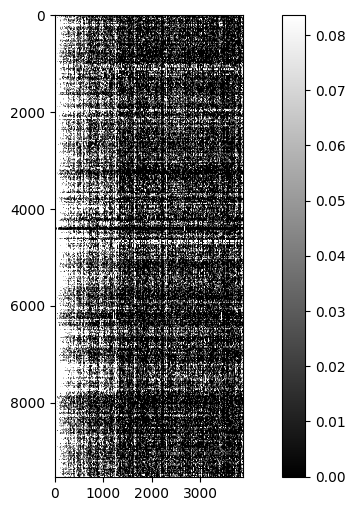

In [20]:

n_samples, n_features = FX.shape
print('number of features (columns): %s' %n_features)
print('number of samples (rows): %s' %n_samples)

# Count the zero entries
zero_count = np.count_nonzero(FX == 0)

print("Number of zero entries:", zero_count)

print("fraction of zero entries:", zero_count/n_samples/ n_features )


if np.isnan(FX).any():
    print("FX contains NaN values.")
else:
    print("FX does not contain NaN values.")
    

# Check for rows that sum up to zero
zero_sum_rows = np.where(FX.sum(axis=1) == 0)[0]

# Check for columns that sum up to zero
zero_sum_columns = np.where(FX.sum(axis=0) == 0)[0]

# Check if there are any zero-sum rows or columns
if zero_sum_rows.size > 0:
    print("There are rows that sum up to zero:", zero_sum_rows)
else:
    print("No rows sum up to zero.")

if zero_sum_columns.size > 0:
    print("There are columns that sum up to zero:", zero_sum_columns)
else:
    print("No columns sum up to zero.")



plt.figure(figsize=(10,6))
im = plt.imshow(FX, cmap='gray', vmax=.01*np.max(FX))
plt.colorbar(im, orientation='vertical')
plt.savefig('FX_weighted.png',dpi=500)

### GENE 2 GENE MATRIX & LINKAGE

takes ca 5 mins

In [21]:

t0 = time.time()

# metric = 'euclidean'
metric = 'cosine'
# USE package to here, much faster!
D = dist.pdist(FX,metric = metric)

L = sch.linkage(D, method = 'average',metric = metric)


print('time.time(): %f' % (time.time()-t0))

time.time(): 249.278592


### optimal cluster number


### Silhouette Score

The Silhouette Score measures how similar an object is to its own cluster compared to other clusters. The score ranges from -1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

To use it:

    Calculate the silhouette score for a range of number of clusters.
    Choose the number of clusters that maximize the silhouette score.

In [27]:
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import squareform
condensed_D = squareform(D) 

# Choosing the number of clusters based on silhouette score
silhouette_scores = []
range_n_clusters = list(range(200, 1020,20))  # Example range from 2 to 9 clusters
for n_clusters in range_n_clusters:
    labels = fcluster(L, n_clusters, criterion='maxclust')
    score = silhouette_score(condensed_D, labels, metric='precomputed')
    silhouette_scores.append(score)

optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print("The optimal number of clusters:", optimal_clusters)

The optimal number of clusters: 1000


Text(0, 0.5, 'silhouette score')

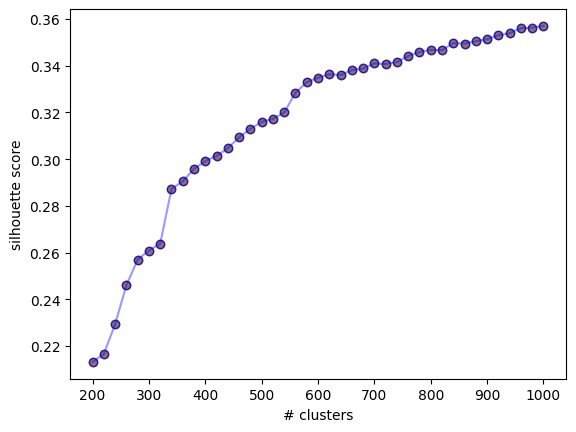

In [28]:
plt.plot(range_n_clusters, silhouette_scores, '-o', label='Silhouette Scores', color='b',alpha=.4)  # '-o' creates lines with circle markers
plt.scatter(range_n_clusters,silhouette_scores,c = '#f8b100',edgecolors='#333333',alpha=0.9)

plt.xlabel('# clusters')
plt.ylabel('silhouette score')

375


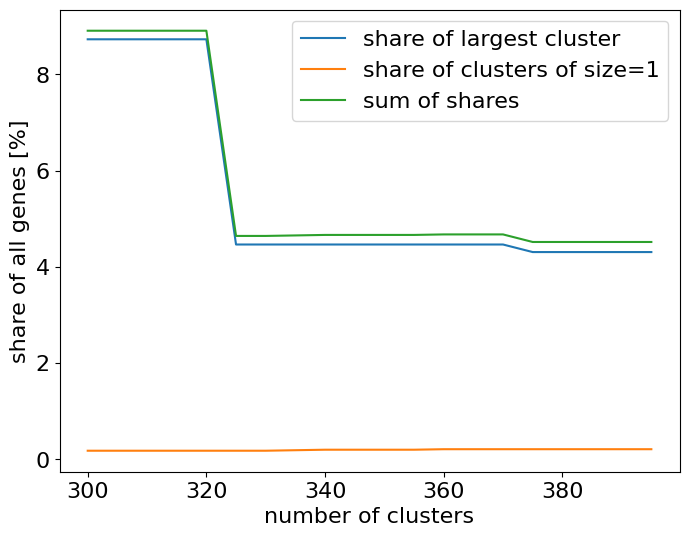

In [22]:
cs_range = range(300,400,5)
l_frac_bigvs1 = []
l_frac_big = []
l_frac_s1 = []
for max_num_clusters in cs_range:
    l_cluster = fcluster(L, max_num_clusters, criterion='maxclust')
    # size of clusters
    d_c_s = {}
    for cl in set(l_cluster):
        d_c_s[cl] =  list(l_cluster).count(cl)

    for a,b in sorted(d_c_s.items(), key = lambda x: x[1], reverse = True)[:1]:
        max_size = b
        max_size_frac = 100.*b/n_samples
#         print('size of largest cluster: %s (cov = %.0f%%)' %(max_size,max_size_frac))

    c_1_number = list(d_c_s.values()).count(1)
    c_1_number_frac = 100.*c_1_number/n_samples
    l_frac_big.append(max_size_frac)
    l_frac_s1.append(c_1_number_frac)
    l_frac_bigvs1.append(max_size_frac+c_1_number_frac)

index_min = np.argmin(np.array(l_frac_bigvs1))
#     print(index_min)
min_cs = cs_range[index_min]

print(min_cs)        


plt.figure(figsize=(8,6))


# plt.bar(range(len(d_c_s.keys()))[:40],sorted(d_c_s.values(),reverse = True)[:40])    
plt.plot(cs_range,l_frac_big,label='share of largest cluster')
plt.plot(cs_range,l_frac_s1, label = 'share of clusters of size=1')
plt.plot(cs_range,l_frac_bigvs1,label='sum of shares')

plt.legend(fontsize =16)
plt.xlabel('number of clusters',fontsize =16)
plt.ylabel('share of all genes [%]',fontsize =16)

ax = plt.gca()
tick_color = 'k'#'#ffffff'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=16)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)



### assign genes to cluster as dictionary

and count the occurrence of cluster sizes

In [23]:
l_cluster = fcluster(L, 335, criterion='maxclust')

d_clID_size = Counter((l_cluster.tolist()))
print('clusterID , #genes in cluster')
c = 0 
sum = 0
for k, v in d_clID_size.items():
    c += 1
    sum += v
    # print(k,v)
print(c,sum)

# dict for size distribution of clusters
d_size_freq = dict(Counter(d_clID_size.values()))


clusterID , #genes in cluster
335 9544


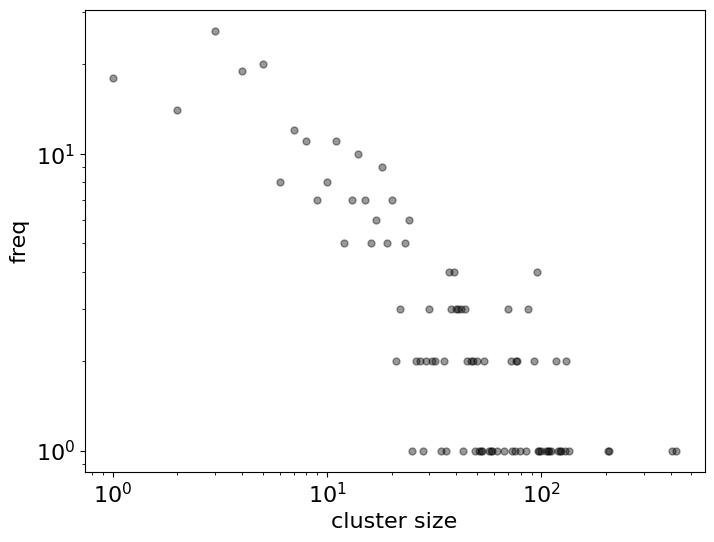

In [24]:
plt.figure(figsize=(8,6))
# plt.bar(range(len(d_c_s.keys()))[:40],sorted(d_c_s.values(),reverse = True)[:40])    
plt.scatter(d_size_freq.keys(),d_size_freq.values(),c = 'k',s = 25,alpha = .4)
plt.xscale('log')
plt.yscale('log')

plt.xlabel('cluster size',fontsize =16)
plt.ylabel('freq',fontsize =16)

ax = plt.gca()
tick_color = 'k'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=16)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)


### node colors

In [25]:
L[L<0.0] = 0.0
  
# minimal size
#  of a cluster to give it a color
min_size = 70

l_small_clusterIDS = [c for c, s in d_clID_size.items() if s < min_size]
print('Only clusters bigger than %s genes get colors.' %min_size)
print('The rest will be gray.')

print('Thus we need %s different colors.' %(len(set(l_cluster))-len(l_small_clusterIDS)))

l_col = generate_colors(len(set(l_cluster))-len(l_small_clusterIDS))
rd.shuffle(l_col)
# l_col = cemm_pal(len(set(l_cluster)))
d_cl_col = {}
c = 0
for cl,size in sorted(d_clID_size.items(), key = lambda x: x[1], reverse = True):
    if size < min_size:
        d_cl_col[cl] = '#888888'
    else:
        d_cl_col[cl] = l_col[c]
    c +=1


# assign colors to each node
d_node_col = {}
d_sym_col = {}

for n, cl in enumerate(l_cluster):
    col = d_cl_col[cl]
    gene = d_idx_gene_feat[n]
    sym = entrez_to_symbols.get(gene, gene)
    d_node_col[gene] = col
    d_sym_col[sym] = col


non_dis_genes = set(G.nodes) - set(d_node_col.keys())
# include the non-annotated nodes as well
non_dis_col = '#444444'
for gene in non_dis_genes:
    sym = entrez_to_symbols.get(gene, gene)
    d_node_col[gene] = non_dis_col
    d_sym_col[sym] = non_dis_col




Only clusters bigger than 70 genes get colors.
The rest will be gray.
Thus we need 42 different colors.


In [26]:
# make dict with clusterID as keys and set of genes as values
d_cl_setgenes = defaultdict(list)

for n, cl in enumerate(l_cluster):
    gene = d_idx_gene_feat[n]
    d_cl_setgenes[cl].append(gene)

# and vice versa
d_gene_clID = {}
for clID, set_genes in d_cl_setgenes.items():
    for gene in set_genes:
        d_gene_clID[gene] = clID



### coordinates according to feature similarities

### UMAP coordinates


In [27]:
## MAKE SURE THAT NO NODES ARE DISCONNECTED!!!
## OTHERHWISE THERE WILL BE PROBLEMS WITH COORDINATES

t0 = time.time()

# for mind in np.arange(.2,4.,.4):
n_neighs = 18
mind = 1.5
spread = 2.

# # two-dimensional
# reducer = umap.UMAP(n_components=2,n_neighbors=n_neighs, metric = 'cosine', min_dist=mind, spread = spread, init = 'spectral', low_memory=True)
# umap_pos_2D = reducer.fit_transform(FX)

# three-dimensional
reducer = umap.UMAP(n_components=3,n_neighbors=n_neighs, metric = 'cosine', min_dist=mind, spread = spread, init = 'spectral', low_memory=True)
umap_pos_3D = reducer.fit_transform(FX)

print('UMAP time : %f ' %  (time.time()-t0))



UMAP time : 36.571495 


In [28]:
# d_umappos_2D = {}
# c = 0
# for row in FX:
#     gene = d_idx_gene_feat[c]
#     xy = umap_pos_2D[c,:].tolist()
#     d_umappos_2D[gene] = xy
#     c += 1


d_umappos_3D = {}
c = 0
for row in FX:
    gene = d_idx_gene_feat[c]
    xyz = umap_pos_3D[c,:].tolist()
    d_umappos_3D[gene] = xyz
    c += 1

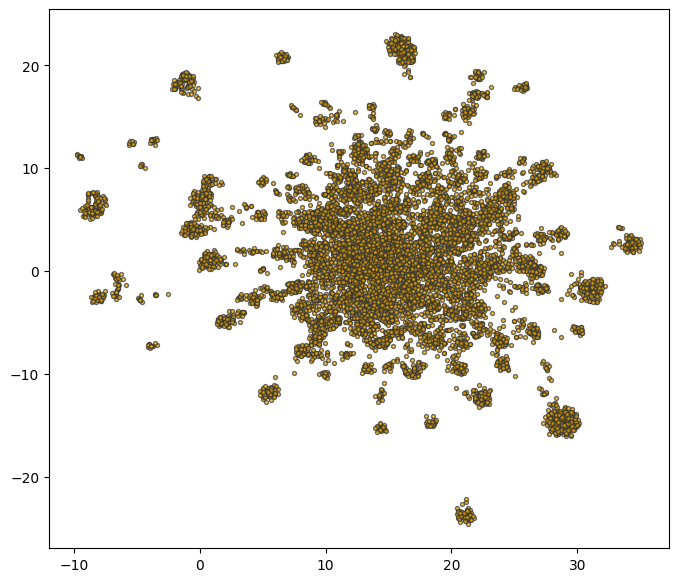

In [29]:
plt.figure(figsize=(8,7))
# plt.scatter(umap_pos[:,0],umap_pos[:,1], s = 20)
# plt.scatter(umap_pos_2D[:,0],umap_pos_2D[:,1], s = 8,c='#f8b100',edgecolors='#333333',alpha=.7)
plt.scatter(umap_pos_3D[:,0],umap_pos_3D[:,1], s = 8,c='#f8b100',edgecolors='#333333',alpha=.7)

Text(0.5, 1.0, 'XZ Projection')

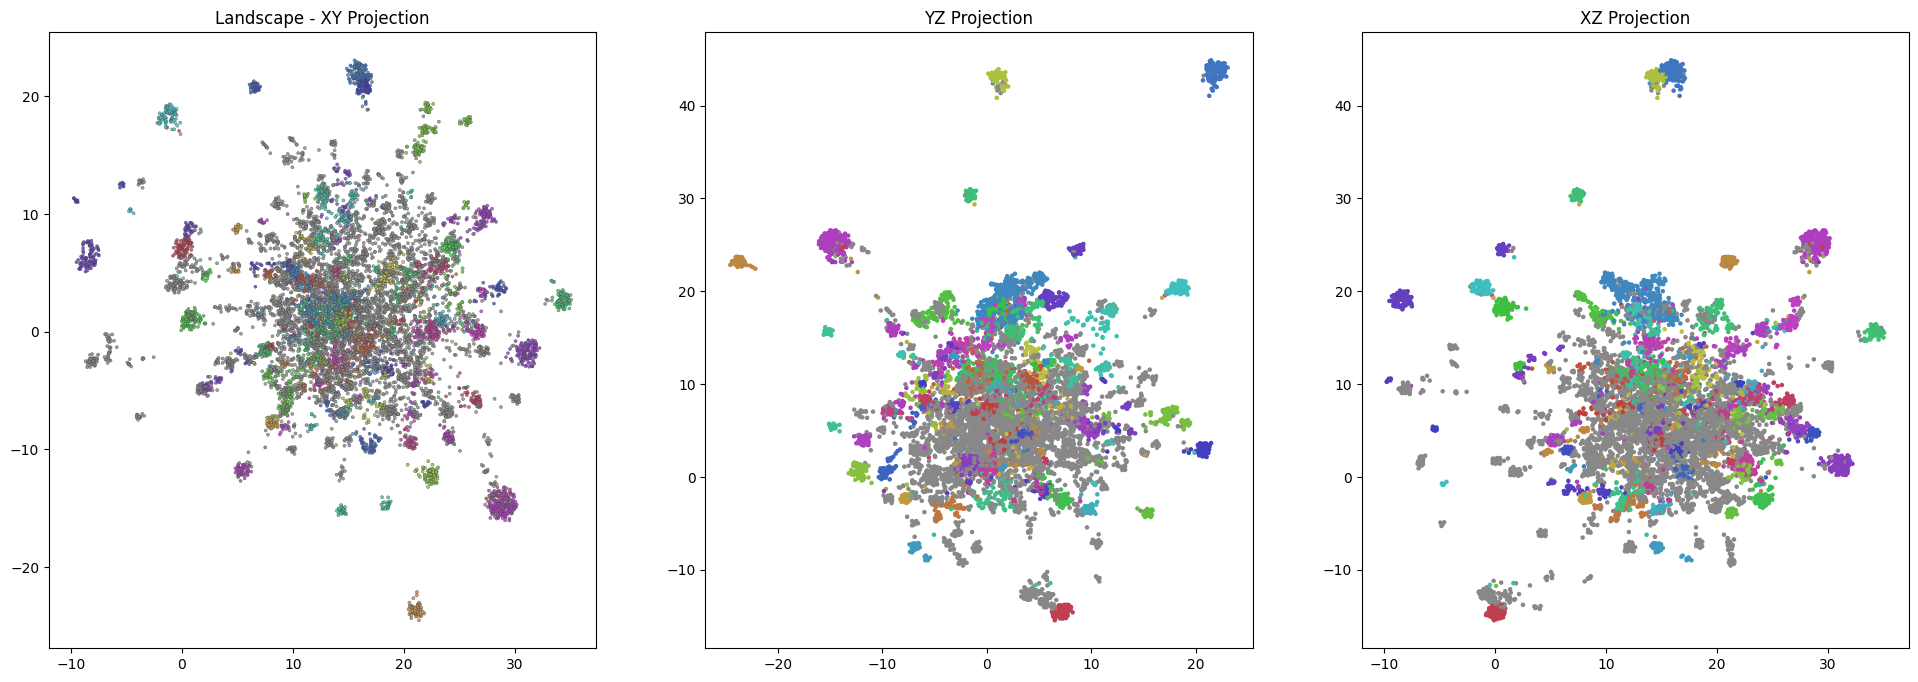

In [30]:
# shuffle colors

rd.shuffle(l_col)
# l_col = cemm_pal(len(set(l_cluster)))
d_cl_col = {}
c = 0
for cl,size in sorted(d_clID_size.items(), key = lambda x: x[1], reverse = True):
    if size < min_size:
        d_cl_col[cl] = '#888888'
    else:
        d_cl_col[cl] = l_col[c]
    c +=1

# assign colors to each node
d_node_col = {}
d_sym_col = {}

for n, cl in enumerate(l_cluster):
    col = d_cl_col[cl]
    gene = d_idx_gene_feat[n]
    sym = entrez_to_symbols.get(gene, gene)
    d_node_col[gene] = col
    d_sym_col[sym] = col


non_dis_genes = set(G.nodes) - set(d_node_col.keys())
# include the non-annotated nodes as well
non_dis_col = '#444444'
for gene in non_dis_genes:
    sym = entrez_to_symbols.get(gene, gene)
    d_node_col[gene] = non_dis_col
    d_sym_col[sym] = non_dis_col

##########################################


# Extract x, y, and z values from the dictionary
x_values = [coord[0] for coord in d_umappos_3D.values()]
y_values = [coord[1] for coord in d_umappos_3D.values()]
z_values = [coord[2] for coord in d_umappos_3D.values()]

# Create a list of colors based on your dictionary
colors = [d_node_col[key] for key in d_umappos_3D.keys()]
# '#40b9d4'#
plt.figure(figsize=(24, 8))
# XY projection
plt.subplot(131)
plt.scatter(x_values, y_values, c=colors, marker='o', s= 5,edgecolors='#444444',linewidths=.3, alpha=.8)
plt.title('Landscape - XY Projection')
# plt.savefig('disease_land_2D.png', dpi=500)
# YZ projection
plt.subplot(132)
plt.scatter(y_values, z_values, c=colors, marker='o', s= 5)
plt.title('YZ Projection')

# XZ projection
plt.subplot(133)
plt.scatter(x_values, z_values, c=colors, marker='o', s= 5)
plt.title('XZ Projection')



In [34]:
genewithnoterms = set(G.nodes()) - set(d_umappos_3D.keys())


x_values = [x for x, y, z in d_umappos_3D.values()]
y_values = [y for x, y, z in d_umappos_3D.values()]
z_values = [z for x, y, z in d_umappos_3D.values()]

# # two-dimensional
# # add nodes with no disease association as ring around the umap layout


min_x = min(x_values)
max_x = max(x_values)
min_y = min(y_values)
max_y = max(y_values)
min_z = min(z_values)
max_z = max(z_values)

# d_x = max_x - min_x
# d_y = max_y - min_y
cms_lcc = (np.mean(x_values),np.mean(y_values),np.mean(z_values))
# cms_lcc = (20,0)
# radius = .5 * max(d_x,d_y)

# d_circle = {}

# for i,gene in enumerate(genewithnoterms):
#     phi = i/(2.*np.pi)
#     x = 1.1*radius * np.cos(phi) + cms_lcc[0]
#     y = 1.1*radius * np.sin(phi) + cms_lcc[1]
#     d_circle[gene] = (x,y)

# d_layout = {**d_umappos, **d_circle}


# # three-dimensional
# add nodes with no disease annotations as fibonacci sphere


# sphere = fibonacci_sphere(len(genewithnoterms),radius=5, center=cms_lcc)
# small sphere
sphere = fibonacci_sphere(len(genewithnoterms),radius=5, center=(-5,-25,-20))

d_sphere_3D = {}
c= 0
for gene in genewithnoterms:
    d_sphere_3D[str(gene)] = sphere[c,:].tolist()
    c += 1

print(c, ' genes without annotations displayed as sphere')

d_layout_3D = {**d_umappos_3D, **d_sphere_3D}




8520  genes without annotations displayed as sphere


In [35]:
len(d_layout_3D.keys())

18064

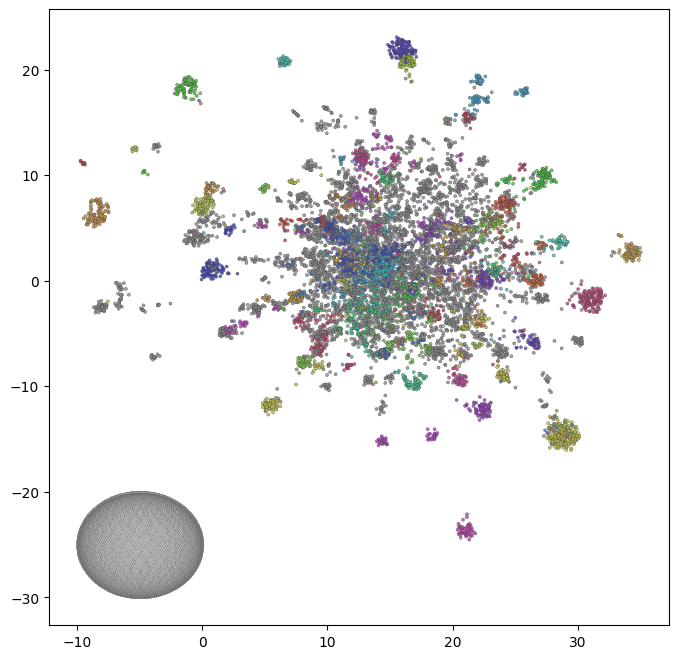

In [36]:
# shuffle colors

rd.shuffle(l_col)


# assign colors to cluster ID
# small clusters to gray
# bigger clusters to colors
d_cl_col = {}
c = 0
for cl,size in sorted(d_clID_size.items(), key = lambda x: x[1], reverse = True):
    if size < min_size:
        d_cl_col[cl] = '#888888'
    else:
        d_cl_col[cl] = l_col[c]
    c +=1

# assign colors to each node from clusters
d_node_col = {}
d_sym_col = {}

for n, cl in enumerate(l_cluster):
    col = d_cl_col[cl]
    gene = d_idx_gene_feat[n]
    sym = entrez_to_symbols.get(gene, gene)
    d_node_col[gene] = col
    d_sym_col[sym] = col

# assign colors to each node from sphere

non_dis_genes = set(G.nodes) - set(d_node_col.keys())
# include the non-annotated nodes as well
non_dis_col = '#bbbbbb'
for gene in non_dis_genes:
    sym = entrez_to_symbols.get(gene, gene)
    d_node_col[gene] = non_dis_col
    d_sym_col[sym] = non_dis_col

##########################################

# Extract x, y, and z values from the dictionary
# x_values = [coord[0] for coord in d_layout.values()]
# y_values = [coord[1] for coord in d_layout.values()]
# z_values = [coord[2] for coord in d_umappos.values()]

# Create a list of colors based on your dictionary
colors = [d_node_col[key] for key in d_umappos_3D.keys()]
plt.figure(figsize=(8, 8))

x_values_s2 = [x for x, y, z in d_sphere_3D.values()]
y_values_s2 = [y for x, y, z in d_sphere_3D.values()]
z_values_s2 = [z for x, y, z in d_sphere_3D.values()]

plt.scatter(x_values, y_values, c=colors, marker='o', s= 5,edgecolors='#444444',linewidths=.3, alpha=.8)
plt.scatter(x_values_s2, y_values_s2, c='#bbbbbb', marker='o', s= 2,edgecolors='#444444',linewidths=.3, alpha=.4)

# plt.savefig('disease_land.png', dpi=500)


### export multiple maps to distinguish too similar coloring

In [67]:
# for m in range(5):    
#     rd.shuffle(l_col)
#     d_cl_col = {}
#     c = 0
#     for cl,size in sorted(d_clID_size.items(), key = lambda x: x[1], reverse = True):
#         if size < min_size:
#             d_cl_col[cl] = '#888888'
#         else:
#             d_cl_col[cl] = l_col[c]
#         c +=1

#     # assign colors to each node
#     d_node_col = {}
#     d_sym_col = {}

#     for n, cl in enumerate(l_cluster):
#         col = d_cl_col[cl]
#         gene = d_idx_gene_feat[n]
#         sym = entrez_to_symbols.get(gene, gene)
#         d_node_col[gene] = col
#         d_sym_col[sym] = col


#     non_dis_genes = set(G.nodes) - set(d_node_col.keys())
#     # include the non-annotated nodes as well
#     non_dis_col = '#444444'
#     for gene in non_dis_genes:
#         sym = entrez_to_symbols.get(gene, gene)
#         d_node_col[gene] = non_dis_col
#         d_sym_col[sym] = non_dis_col


#     # Create a list of colors based on your dictionary
#     colors = [d_node_col[key] for key in d_layout.keys()]
#     # '#40b9d4'#
#     plt.figure(figsize=(8, 8))

#     plt.scatter(x_values, y_values, c=colors, marker='o', s= 5)
#     plt.title('XY Projection')

#     plt.savefig('landscape_%s.png' %m)

#     plt.clf()

make pictures that highlight only one of the clusters at ones with its label 

In [224]:
# l_col = generate_colors(len(set(l_cluster))-len(l_small_clusterIDS))
# rd.shuffle(l_col)

# set_bigclusters = set(l_cluster)-set(l_small_clusterIDS)

# for i,cID in enumerate(set_bigclusters):    
#     # rd.shuffle(l_col)
#     d_cl_col = {}
#     for cl,size in sorted(d_clID_size.items(), key = lambda x: x[1], reverse = True):
#         if size < min_size:
#             d_cl_col[cl] = '#888888'
#         elif cl == cID:
#             d_cl_col[cl] = l_col[i]
#         else:
#             d_cl_col[cl] = '#888888'


#     # assign colors to each node
#     d_node_col = {}
#     d_sym_col = {}

#     for n, cl in enumerate(l_cluster):
#         col = d_cl_col[cl]
#         gene = d_idx_gene_feat[n]
#         sym = entrez_to_symbols.get(gene, gene)
#         d_node_col[gene] = col
#         d_sym_col[sym] = col


#     non_dis_genes = set(G.nodes) - set(d_node_col.keys())
#     # include the non-annotated nodes as well
#     non_dis_col = '#444444'
#     for gene in non_dis_genes:
#         sym = entrez_to_symbols.get(gene, gene)
#         d_node_col[gene] = non_dis_col
#         d_sym_col[sym] = non_dis_col


#     # Create a list of colors based on your dictionary
#     colors = [d_node_col[key] for key in d_umappos.keys()]
#     # '#40b9d4'#
#     plt.figure(figsize=(8, 8))

#     plt.scatter(x_values, y_values, c=colors, marker='o', s= 5)
#     plt.title('cluster: %s' %cID)

#     plt.savefig('landscape_%s.png' %cID)

#     plt.clf()

### cluster characterization

In [38]:
sig_level = .01

# big clusters:

set_bigclusters = set(l_cluster)-set(l_small_clusterIDS)

# select disease genes as background only 
background = len(d_sample_attributes.keys())

d_cl_charac_terms = {}
for cID in set_bigclusters:
    sampleset = d_cl_setgenes[cID]
    # sampleset = [int(x) for x in d_cl_setgenes[cID]]
    d_dis_p = fisher_test(sig_level,sampleset,d_sample_attributes,d_attributes_sample,background)
    l_terms_pvals = []
    for x,p in d_dis_p.items():
        if p < sig_level:
            l_terms_pvals.append([x,p])
    d_cl_charac_terms[cID] = l_terms_pvals



In [39]:
for cID, set_terms in d_cl_charac_terms.items():
    print('cluster no: ', cID)
    print('terms:')
    for term,p_val in set_terms:
        try:
            if p_val > 1e-14:
                minlog_p_val = - np.log(p_val)
            else:
                minlog_p_val = 100

            print(term,d_term_name[term],d_do_subvol[term],minlog_p_val)
        except:
            pass
    print('\n')

cluster no:  130
terms:
DOID:0060286 combined oxidative phosphorylation deficiency 1 100
DOID:0050730 coenzyme Q10 deficiency disease 1 8.238277215458806
DOID:655 inherited metabolic disorder 323 100
DOID:3652 Leigh disease 1 17.295330571388103
DOID:3762 cytochrome-c oxidase deficiency disease 1 10.529913572521158
DOID:700 mitochondrial metabolism disease 42 100
DOID:0014667 disease of metabolism 430 100
DOID:0060536 mitochondrial complex I deficiency 1 19.500966060870034


cluster no:  261
terms:
DOID:0060194 amyotrophic lateral sclerosis type 2 1 10.618210607838266
DOID:0060196 amyotrophic lateral sclerosis type 4 1 4.779251958438182
DOID:231 motor neuron disease 46 100
DOID:1289 neurodegenerative disease 215 13.937545765844286
DOID:332 amyotrophic lateral sclerosis 28 100
DOID:0060193 amyotrophic lateral sclerosis type 1 1 100


cluster no:  136
terms:
DOID:1426 ureteral disease 6 100
DOID:2527 nephrosis 4 100
DOID:557 kidney disease 97 100
DOID:10966 lipoid nephrosis 1 100
DOID:142

Unfortunately there is no TF-IDF result for the labels

So I am doing them manually...

In [71]:
d_cluster_label = {
    130: 'metabolic disorder',
    261 : 'amyotrophic lateral sclerosis',
	136 : 'nephritis',
	9 : 'no label',
	264 : 'neurodegenerative disease',
	140 : 'cardiomyopathy',
	174 : 'endometriosis',
	28 : 'AIDS',
	284 : 'leukemia',
	158 : 'cardiovascular disease',
	37 : 'no label',
	41 : 'monogenic disease',
	42 : 'autosomal genetic disease',
	169 : 'Alzheimers disease',
	297 : 'prostate cancer',
	173 : 'depression/anxiety',
	174 : 'schizophrenia',
	176 : 'substance dependence',
	50 : 'anemia',
	306 : 'skin cancer',
	309 : 'kidney/urinary cancer',
	313 : 'biliary tract cancer',
	314 : 'liver cancer',
	315 : 'stomach cancer',
	318 : 'large intestine cancer',
	193 : 'congenital diseases',
	194 : 'autism',
	197 : 'learning disorder',
	327 : 'breast and thoracic cancer',
	200 : 'neurological/visual disorders',
	203 : 'intellectual disability',
	332 : 'head and neck cancer',
	205 : 'chromosomal/metabolic disorders',
	206 : 'eye and adnexa disease',
	334 : 'lung cancer',
	208 : 'muscular and limb-girdle dystrophies',
	209 : 'dilated cardiomyopathy',
	335 : 'malignant and benign cancers',
	212 : 'myopathy',
	225 : 'rheumatoid arthritis',
	121 : 'lipid storage disease',
	251 : 'epilepsy'
}

### make graph object 4 VR

In [106]:
## MAKE SURE THAT NO NODES ARE DISCONNECTED!!!
## OTEHRHWISE THERE WILL BE PROBLEMS WITH COORDINATES


t0 = time.time()

# for mind in np.arange(.2,4.,.4):
n_neighs = 18
mind = 1.5
spread = 2.

# # two-dimensional
# reducer = umap.UMAP(n_components=2,n_neighbors=n_neighs, metric = 'cosine', min_dist=mind, spread = spread, init = 'spectral', low_memory=True)
# umap_pos_2D = reducer.fit_transform(FX)

# three-dimensional
reducer = umap.UMAP(n_components=3,n_neighbors=n_neighs, metric = 'cosine', min_dist=mind, spread = spread, init = 'spectral', low_memory=True)
umap_pos_3D = reducer.fit_transform(FX)


print('UMAP time : %f ' %  (time.time()-t0))

d_umappos_3D = {}
c = 0
for row in FX:
    gene = d_idx_gene_feat[c]
    xy = umap_pos_3D[c,:].tolist()
    d_umappos_3D[gene] = xy
    c += 1

UMAP time : 19.592549 


add fibo sphere for remaining genes

In [161]:
genewithnoterms = set(G.nodes()) - set(d_umappos_3D.keys())
lcc_x_values = [x for x, y, z in d_umappos_3D.values()]
lcc_y_values = [y for x, y, z in d_umappos_3D.values()]
lcc_z_values = [z for x, y, z in d_umappos_3D.values()]

# # two-dimensional
# # add nodes with no disease association as ring around the umap layout


min_x = min(lcc_x_values)
max_x = max(lcc_x_values)
min_y = min(lcc_y_values)
max_y = max(lcc_y_values)
min_z = min(lcc_z_values)
max_z = max(lcc_z_values)

d_x = max_x - min_x
d_y = max_y - min_y
d_z = max_z - min_z

cms_lcc = (np.mean(lcc_x_values),np.mean(lcc_y_values),np.mean(lcc_z_values))
# cms_lcc = (-5,10)
radius = .6 * max(d_x,d_y,d_z)

# d_circle = {}

# for i,gene in enumerate(genewithnoterms):
#     phi = i/(2.*np.pi)
#     x = 1.1*radius * np.cos(phi) + cms_lcc[0]
#     y = 1.1*radius * np.sin(phi) + cms_lcc[1]
#     d_circle[gene] = (x,y)

# d_layout = {**d_umappos, **d_circle}


# three-dimensional
# add nodes with no disease annotations as fibonacci sphere

# make much smaller sphere in a corner
cms_lcc = (10,20,-7)
radius = 5

sphere = fibonacci_sphere(len(genewithnoterms),radius=radius, center=cms_lcc)

d_fibo = {}
c= 0
for gene in genewithnoterms:
    d_fibo[str(gene)] = sphere[c,:].tolist()
    c += 1

d_layout_3D = {**d_umappos_3D, **d_fibo}


# print(c, ' genes without annotations displayed as sphere')


Map everything into gene symbols

In [165]:
# Creating a new graph with updated labels
G_sym = nx.Graph()

# Relabeling nodes based on the mapping
for node in G.nodes():
    new_label = entrez_to_symbols.get(node, node)
    G_sym.add_node(new_label)

# Adding edges to the new graph with updated labels
c = 0
for edge in G.edges():
    node1, node2 = edge
    new_node1 = entrez_to_symbols.get(node1, node1)
    new_node2 = entrez_to_symbols.get(node2, node2)
    G_sym.add_edge(new_node1, new_node2)
    c += 1

d_sym_umap_3D = {}
for gene, xyz in d_layout_3D.items():
    sym = entrez_to_symbols.get(gene, gene)
    d_sym_umap_3D[sym] = xyz

# make_json(name='umap_PPI', network = G_sym, positions = d_sym_umap)

genewithnoterms_syms = []
for node in G.nodes():
    if node in genewithnoterms:
        symbol = entrez_to_symbols.get(node, node)
        genewithnoterms_syms.append(symbol)

In [168]:
plotly_preview(G_sym, Gpos=d_sym_umap_3D, node_colors=d_sym_col, edge_colors=None, links = False, subset_smaller_nodes = genewithnoterms_syms)

make cluster labels to hover text


In [228]:

d_sym_clusterlabel = {}

# for node_sym in G_sym.nodes():
for ent_node in list(G.nodes()):
    symbol = entrez_to_symbols.get(ent_node, ent_node)
    if ent_node in d_gene_clID.keys():
        clID = d_gene_clID[ent_node]
        try:
            label = 'Gene: ' +  symbol + '<br>Cluster: ' + d_cluster_label[clID]
        except KeyError:
            label = 'no label'
        d_sym_clusterlabel[symbol] = label

    else:
        d_sym_clusterlabel[symbol] = 'Gene: ' +   symbol + '<br>' + 'Cluster: no label'
       


In [235]:
plotly_preview(G_sym, Gpos=d_sym_umap_3D, node_colors=d_sym_col, edge_colors=None, links = False, subset_smaller_nodes = genewithnoterms_syms, hoverlabels = d_sym_clusterlabel )

### make annotations

key: symbol list: [disease1, disease2, ...] as names 



In [53]:
d_sym_disease_annotations = {}

# for gene, l_dis in d_sample_attributes.items():
for gene in G.nodes():
    sym = entrez_to_symbols.get(gene, gene)
# for gene, l_dis in d_sample_attributes.items():
    l_dis_names = []
    # print(gene)
    if gene in d_sample_attributes.keys():
        for dis in d_sample_attributes[gene]:
            dis_name = d_term_name[dis]
            l_dis_names.append(dis_name)
    else:    
        pass
    d_sym_disease_annotations[sym] = l_dis_names


### pickle dumps for genereting the JSONs for DataDiVR

In [68]:
pk.dump( d_sym_umap, open( "d_sym_umap.pkl", "wb" ) )
pk.dump( G_sym, open( "G_sym.pkl", "wb" ) )
pk.dump( d_sym_disease_annotations, open( "d_sym_disease_annotations.pkl", "wb" ) )
pk.dump( d_sym_col, open( "d_sym_col.pkl", "wb" ) )






In [67]:
print(set(G_sym.nodes()) ==  set(d_sym_umap.keys()))
print(set(G_sym.nodes()) ==  set(d_sym_disease_annotations.keys()))
print(set(G_sym.nodes()) ==  set(d_sym_col.keys()))
print(len(d_sym_col.keys()))

True
True
True
18064


In [155]:
plotly_preview(G_sym, Gpos=d_sym_umap_3D, node_colors=d_sym_col, edge_colors=None, links = False)

In [139]:
G_test = nx.barbell_graph(8,5)

pos_test = nx.spring_layout(G_test,dim=3)

plotly_preview(G_test, Gpos=pos_test)

In [75]:
make_json(name = '02_PPI_disease_umap', network=G_sym, positions=d_sym_umap, annotations = d_sym_disease_annotations, node_color = d_sym_col)

### spring layout

In [73]:
# pos_spring = nx.spring_layout(G, dim=3, pos = nx.spectral_layout(G, dim=3), iterations=500)

# Pickle the object
# with open('physicalPPI_3Dspring_pos.pkl', 'wb') as file:
#     pk.dump(pos_spring, file)

# # Load the pickled object
with open('Data/physicalPPI_3Dspring_pos.pkl', 'rb') as file:
    pos_spring = pk.load(file)


d_sym_spring = {}

for gene, xyz in pos_spring.items():
    sym = entrez_to_symbols.get(gene, gene)
    d_sym_spring[sym] = xyz

# plotly_preview(G,pos_spring,node_colors = '#f8b100',outfile = 'PPI_spring.html')


In [74]:
make_json(name = '01_PPI_disease_spring', network=G_sym, positions=d_sym_spring, annotations = d_sym_disease_annotations, node_color = d_sym_col)

### spring hairball for VR
(i)   spring no colors
(ii)  spring, plain disease colors
(iii) spring, enriched disease colors


In [217]:
# rewrite network and pos dict into gene symbols

# # Creating a new graph with updated labels
# G_sym = nx.Graph()

# # Relabeling nodes based on the mapping
# for node in G.nodes():
#     new_label = entrez_to_symbols.get(node, node)
#     G_sym.add_node(new_label)

# # Adding edges to the new graph with updated labels
# c = 0
# for edge in G.edges():
#     node1, node2 = edge
#     new_node1 = entrez_to_symbols.get(node1, node1)
#     new_node2 = entrez_to_symbols.get(node2, node2)
#     G_sym.add_edge(new_node1, new_node2)
#     c += 1
    # if c>2:
    #     break

d_sym_spring = {}

for gene, xyz in pos_spring.items():
    sym = entrez_to_symbols.get(gene, gene)
    d_sym_spring[sym] = xyz


# make_json(name='spring_PPI', network = G_sym, positions = d_sym_spring)

In [219]:
# make sure that all node keys are talking to each other 
# All fine if all 0 
print(len(set(pos_spring.keys()) - set(G.nodes())))
print(len(set(G.nodes())- set(pos_spring.keys())))

print(len(set(d_umappos.keys()) - set(G.nodes())))
print(len(set(G.nodes())- set(d_umappos.keys())))

0
0
0
0


### make Eigenlayout

In [87]:
d_sym_eigenpos = eigenlayout(G_sym, dim=3, n_lam=30, n_neighs=15, spread=1.0)

Text(0.5, 1.0, 'XZ Projection')

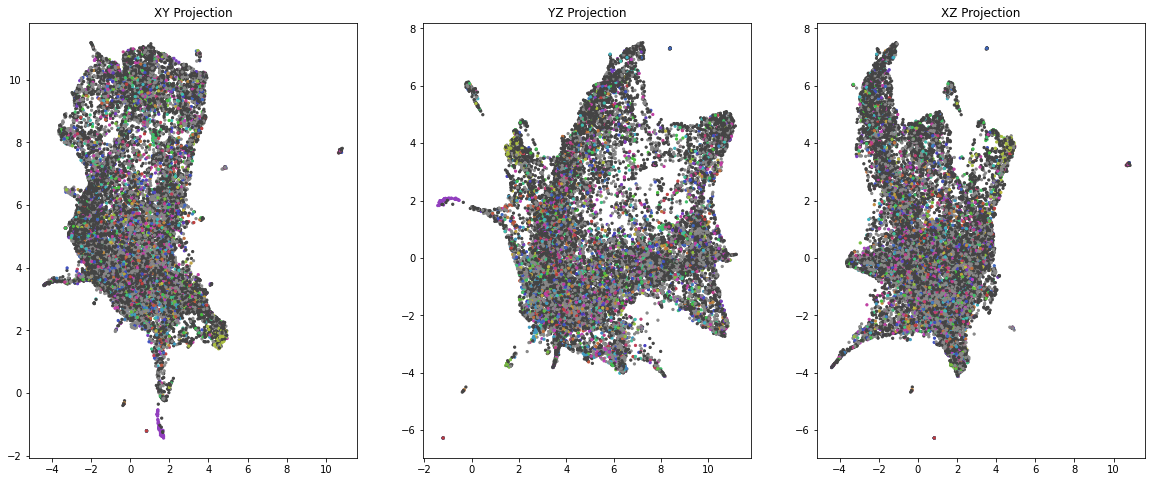

In [89]:


# Extract x, y, and z values from the dictionary
x_values = [coord[0] for coord in d_sym_eigenpos.values()]
y_values = [coord[1] for coord in d_sym_eigenpos.values()]
z_values = [coord[2] for coord in d_sym_eigenpos.values()]

# Create a list of colors based on your dictionary
colors = [d_sym_col[key] for key in d_sym_eigenpos.keys()]
# '#40b9d4'#
plt.figure(figsize=(20, 8))
# XY projection
plt.subplot(131)
plt.scatter(x_values, y_values, c=colors, marker='o', s= 5)
plt.title('XY Projection')

# YZ projection
plt.subplot(132)
plt.scatter(y_values, z_values, c=colors, marker='o', s= 5)
plt.title('YZ Projection')

# XZ projection
plt.subplot(133)
plt.scatter(x_values, z_values, c=colors, marker='o', s= 5)
plt.title('XZ Projection')

# This updated code will correctly use the XYZ coordinates and the corresponding colors from the d_node_col dictionary to create the projections. Thanks for catching that mistake, bro! 🙌🎨


In [90]:
make_json(name = '03_PPI_disease_eigen', network=G_sym, positions=d_sym_eigenpos, annotations = d_sym_disease_annotations, node_color = d_sym_col)

### color disease genes

In [221]:
d_node_color_disRed_noBlue = {}

for gene in G.nodes():
    if gene in d_sample_attributes.keys():
        d_node_color[d_node_color_disRed_noBlue[gene]] = '#d2323c'
    else:
        d_node_color[d_node_color_disRed_noBlue[gene]] = '#40b9d4'
        
d_node_color_disRed_nogray = {}
for gene in G.nodes():
    if gene in d_sample_attributes.keys():
        d_node_color[d_node_color_disRed_nogray[gene]] = '#d2323c'
    else:
        d_node_color[d_node_color_disRed_nogray[gene]] = '#99999932'
        


In [133]:


# # identify disconnected vertices
# disconnected = umap.utils.disconnected_vertices(reducer)

# # print the indices of the disconnected vertices
# indices = np.where(disconnected)[0]

# print(indices)

# # what genes are those?

# for idx in indices:
#     gene = d_idx_gene_feat[idx]
#     print('entrezID: ', gene)
#     print(d_gene_terms_all[gene])

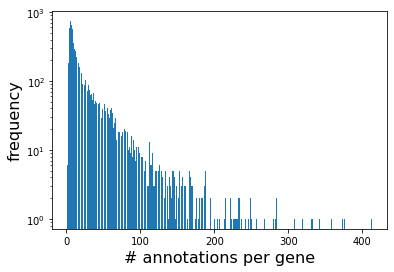

In [135]:
l_numofterms = [len(x) for x in d_gene_terms_all.values()]

d_size_freq = Counter(l_numofterms)

plt.bar(d_size_freq.keys(),d_size_freq.values())
plt.xlabel('# annotations per gene', fontsize = 16)
plt.ylabel('frequency', fontsize = 16)
plt.yscale('log')

In [ ]:
# check the entries in the feature matrix for disconnected nodes:
print(len(FX[8113,:]))

print(Counter(FX[11010,:]))

4420
Counter({0.0: 4419, 6.0613672609730544: 1})


In [172]:
L[L<0.0] = 0.0
  

# # NORMALIZE COORDINATES
# l_x = X_tsne2D[:,0]
# l_y = X_tsne2D[:,1]

# NORMALIZE COORDINATES
noiselevel = .2
l_x = [x+np.random.normal(0.,noiselevel) for x in umap_pos[:,0]]
l_y = [y+np.random.normal(0.,noiselevel) for y in umap_pos[:,1]]
l_z = [z+np.random.normal(0.,noiselevel) for z in umap_pos[:,2]]


l_xn = normalize_mylist(l_x)
l_yn = normalize_mylist(l_y)
l_zn = normalize_mylist(l_z)

posG = {}
for gene in d_gene_terms_all.keys():
    idx = d_gene_idx_feat[gene]
    posG[gene] = (l_xn[idx],l_yn[idx],l_zn[idx])


# CREATE HALO OUT OF NON-ANNOTATED AND DISCONNECTED GENES:
# NUMBER OF NON-ANNOTATED GENES:
n_nongenes = len(genewithnoterms)
# divide 360 by this number to get angle increments
deg_i = 2.*np.pi / n_nongenes
l_xno = []
l_yno = []
l_zno = []

x0 = min(l_xn)+.5
y0 = min(l_yn)+.5
z0 = min(l_zn)+.5

# radius = max([.6*(max(l_xn)-min(l_xn)),.6*(max(l_yn)-min(l_yn)),.6*(max(l_zn)-min(l_zn))])

# n_nongenes = G.number_of_nodes()-n_samples

# ################################################
# #
# #   TWO DIMENSIONS
# #
# # divide 360 by this number to get angle increments
# deg_i = 2.*np.pi / n_nongenes
# for g in range(n_nongenes):
#     x = radius*np.cos(g*deg_i) + x0
#     y = radius*np.sin(g*deg_i) + y0
#     l_xno.append(x)
#     l_yno.append(y)

################################################
#
#   THREE DIMENSIONS
#

xyz_sphere = fibonacci_sphere(n_nongenes)
l_xno, l_yno, l_zno = xyz_sphere[:, 0], xyz_sphere[:, 1], xyz_sphere[:, 2]


# len_tsne = 0
l_colorofgenes = []
d_gene_xy = {}
d_gene_color = {}
for n in range(len(umap_pos[:,0])):
    gene = d_idx_gene_feat[n]
    cluster = l_cluster[n]
    l_colorofgenes.append(d_cl_col[cluster])
    d_gene_xy[gene] = (l_xn[n],l_yn[n],l_zn[n])
    d_gene_color[str(gene)] = d_cl_col[cluster]
    # len_tsne += 1


# colors for non-umaped genes (not annotated in HALO)
d_col_temp = {}
for gene in set(G.nodes())-set(d_gene_color.keys()):
    d_col_temp[gene] = '#aaaaaa'

d_gene_color.update(d_col_temp)



Image generated



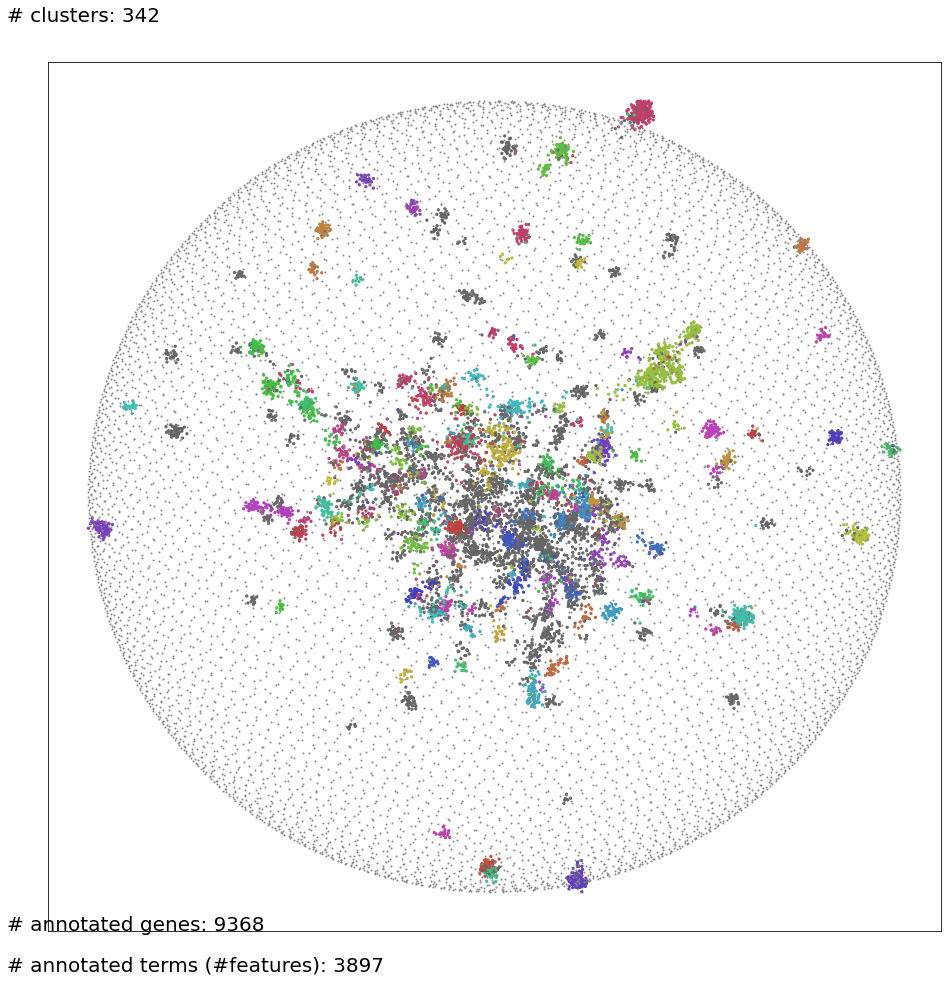

In [173]:
    
plt.figure(figsize=(16,16))
plt.scatter(l_xn,l_yn, s = 5,c=l_colorofgenes)
plt.scatter(l_xno,l_yno, s = 1,c='#888888')
plt.text(-0.1,-0.05,'# annotated genes: %s' %n_samples, fontsize = 20)
plt.text(-0.1,-.1,'# annotated terms (#features): %s' %(n_features), fontsize = 20)

plt.text(-.1,1.1,'# clusters: %s' %len(set(l_cluster)), fontsize = 20)
# plt.text(0.35,1.05,'r = %.2f' %r, fontsize = 30)
# plt.text(0.5,1.05,r'$\alpha$ = %.2f' %alpha, fontsize = 30)


ax = plt.gca()
tick_color = '#ffffff'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=16)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)


# plt.savefig('2Dtsne_pos/enrich_dozerofiltered_r%.2fa%.2f.png' %(r,alpha))  
print('Image generated\n')
# plt.clf()


Text(0, 0.5, 'Y')

<Figure size 1152x1152 with 0 Axes>

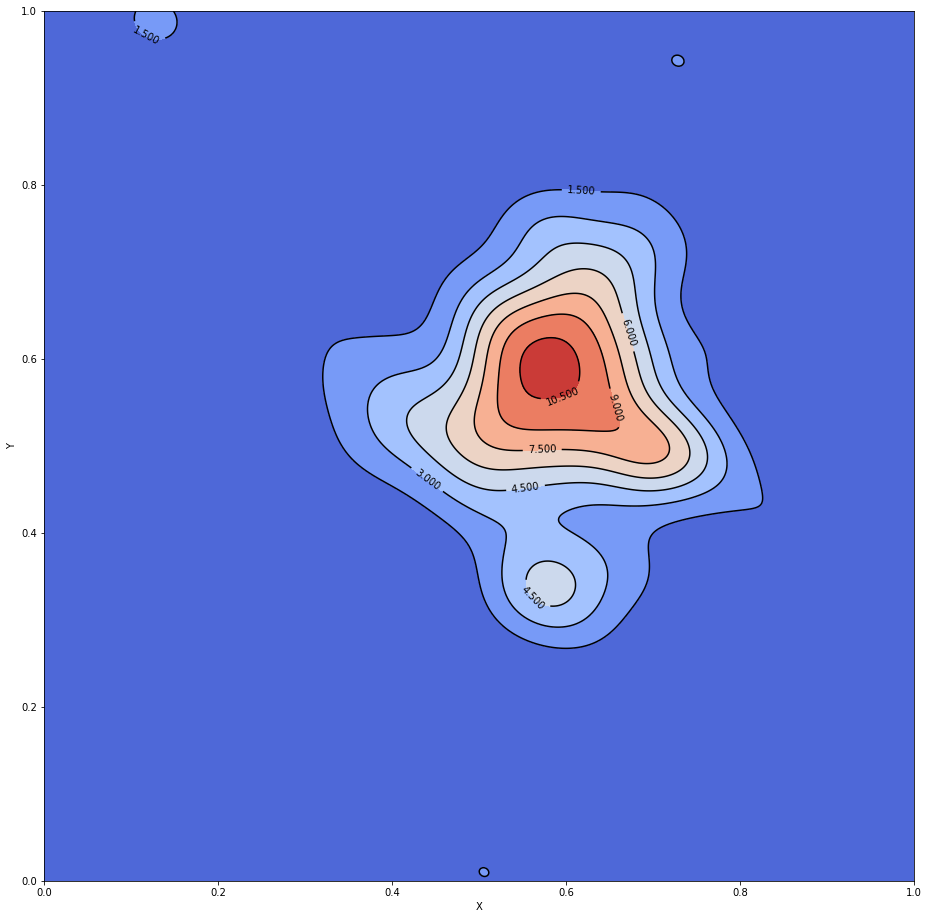

In [88]:
from scipy.stats import kde

# Create a 2D kernel density estimate
k = kde.gaussian_kde([l_xn, l_yn])

# Define the grid over which to evaluate the density estimate
xmin, xmax = np.min(l_xn), np.max(l_xn)
ymin, ymax = np.min(l_yn), np.max(l_yn)
xx, yy = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Evaluate the density estimate at each point on the grid
f = np.reshape(k(positions).T, xx.shape)

# Create a contour plot of the density estimate
plt.figure(figsize=(16,16))

fig, ax = plt.subplots(figsize=(16,16))
cfset = ax.contourf(xx, yy, f, cmap='coolwarm')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')

In [66]:
# hover labels: clusterID and rank of cluster by size (largest cluster is first)

d_cluster_rank ={}
rank = 1
for c,s in sorted(d_c_s.items(), key = lambda x: x[1], reverse = True):
    d_cluster_rank[c] = rank
    rank += 1

gene_cluster_rank_dict = {}
d_symbol = {}
for i, (sample, features) in enumerate(d_gene_terms_all.items()):
    # row_idx = sample_ids[i]
    clusterID = l_cluster[i]
    rank = d_cluster_rank[clusterID]
    gene_cluster_rank_dict[sample] = (clusterID,rank)
    try:
        sym = entrez_to_symbols[str(sample)]
    except:
        sym = sample
    d_symbol[sample] = sym



In [67]:

fig = pgo.Figure()

# Add scatter plot with hovering labels
fig.add_trace(
    pgo.Scatter3d(
        x=l_xn,
        y=l_yn,
        z=l_zn, # new third coordinate
        mode='markers',
        marker=dict(
            size=3,
            color=l_colorofgenes,
            colorscale='Viridis',
            opacity=0.7,
            colorbar=dict(
                thickness=20,
                ticklen=4,
                title='Cluster',
                titleside='right',
                titlefont=dict(size=16),
            ),
        ),
        text=[f"Gene: {d_symbol[gene]}<br>Cluster: {cluster}<br>Rank: {rank}" for gene, (cluster, rank) in gene_cluster_rank_dict.items()],
        hovertemplate='%{text}<extra></extra>'
    )
)

# Add halo out of non-annotated genes
fig.add_trace(
    pgo.Scatter3d(
        x=l_xno,
        y=l_yno,
        z=l_zno, # new third coordinate
        mode='markers',
        marker=dict(
            size=1,
            color='#aaaaaa',
        ),
    )
)

# # Add text annotations to the plot
# annotations=[
#     dict(
#         text="Point {}".format(i+1),
#         x=x[i], y=y[i], z=z[i],
#         showarrow=False,
#         font=dict(size=12, color='black'),
#     )
#     for i in range(len(x))
# ]

# fig.update_layout(scene=dict(annotations=annotations))

# Set layout and axis properties
fig.update_layout(
    width=3177,
    height=1635,
    title='Gene Clustering',
    scene=dict(
        xaxis=dict(
            tickfont=dict(size=16, color='#ffffff'),
            title='UMAP 1',
            titlefont=dict(size=18, color='#ffffff'),
            range=[0, 1],
        ),
        yaxis=dict(
            tickfont=dict(size=16, color='#ffffff'),
            title='UMAP 2',
            titlefont=dict(size=18, color='#ffffff'),
            range=[0, 1],
        ),
        zaxis=dict(
            tickfont=dict(size=16, color='#ffffff'),
            title='UMAP 3', # new z-axis title
            titlefont=dict(size=18, color='#ffffff'),
            range=[0, 1],
        )
    ),
    plot_bgcolor='#333333',
    paper_bgcolor='#333333',
)


# Export as external HTML file
fig.write_html('Physical_PPI_DO_NICE.html', auto_open=True)


### Cluster CHARACTERIZATION

largest cluster contains 197 genes.
there are 15 clusters of size 1
there are 59 clusters of size smaller than 5
there are 114 clusters bigger than 10 genes


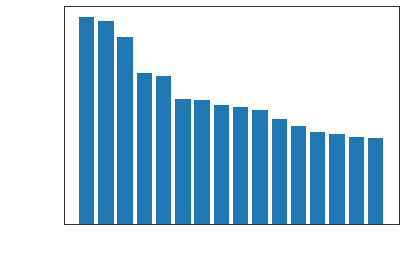

In [68]:
# SIZE DISTRIBUTION
# size of clusters
d_c_s = {}
for cl in set(l_cluster):
    d_c_s[cl] =  list(l_cluster).count(cl)

for cid,b in sorted(d_c_s.items(), key = lambda x: x[1], reverse = True)[:1]:
    print('largest cluster contains %s genes.' %b)

l_1 = [x for x in d_c_s.values() if x==1 ]    
print('there are %s clusters of size 1' %len(l_1))   
l_under5 = [x for x in d_c_s.values() if x<5 ]    
print('there are %s clusters of size smaller than 5' %len(l_under5))  
l_over10 = [x for x in d_c_s.values() if x>10 ]    
print('there are %s clusters bigger than 10 genes' %len(l_over10))     
    
plt.bar(range(len(d_c_s.keys()))[:len(l_col)],sorted(d_c_s.values(),reverse = True)[:len(l_col)])    
plt.ylabel('# genes in cluster',fontsize = 16)
plt.xlabel('cluster number',fontsize = 16)
ax = plt.gca()
tick_color = '#ffffff'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=16)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)
    




In [70]:
# CLUSTER VOLUME AND CONTENT

# d_go_names = turnGOids_GOnames(category = branch)


# LOOP THROUGH ALL CLUSTERS STARTING WITH THE LARGEST 

c = 0
l_cid = []
d_cluster_terms = {}
d_cluster_genes = {}
for cid, f in sorted(d_c_s.items(), key = lambda x: x[1], reverse = 1):
#     print(cid)
    l_cid.append(cid)

    # COLLECT ALL GENES FROM CLUSTER
    l_clustergenes = []
    c = 0
    for idx in l_cluster:
        if idx == cid:
            l_clustergenes.append(d_idx_gene_feat[c])
        c += 1
        
    d_cluster_genes[cid] = l_clustergenes
    ########################################
    # COLLECT ALL TERMS INCLUDED IN CLUSTER
    l_terms = []
    # Loop through genes
    c = 0
    for gene in l_clustergenes:
        termset = list(d_gene_terms_all[gene])
        l_terms += termset  
#         try:
#             termset = list(d_gene_terms_all[gene])
#             l_terms += termset        
#         except KeyError:
#             c += 1
#             termset = []
#             l_terms += termset        
#     print('error occurred %s times' %c)
             
    d_cluster_terms[cid] = l_terms

    
# CLUSTER POSITION
    
d_cluster_xyz_var = {}
c = 0
for cid, f in sorted(d_c_s.items(), key = lambda x: x[1], reverse = 1):    
    l_x1 = []
    l_y1 = []
    l_z1 = []

    for gene in d_cluster_genes[cid]:
        pos = d_gene_xy[gene]
        l_x1.append(pos[0])
        l_y1.append(pos[1])
        l_z1.append(pos[2])

    d_cluster_xyz_var[cid] = (np.mean(l_x1),np.mean(l_y1),np.mean(l_z1),np.std(l_x1),np.std(l_y1),np.std(l_z1))  
d_rank_cid = {}
rank = 1 
tbl = PrettyTable(['rank','Cluster number', '# genes', '# all terms', '# unique terms', 'position','spread', 'color'])
for cid,terms in d_cluster_terms.items():    
    d_rank_cid[rank] = cid

#     print(cid,d_clid_numgenes[cid],len(terms))
    if d_c_s[cid] > min_size:
        x_pos = round(d_cluster_xyz_var[cid][0],2)
        y_pos = round(d_cluster_xyz_var[cid][1],2)
        del_x_pos = round(d_cluster_xyz_var[cid][2],2)
        del_y_pos = round(d_cluster_xyz_var[cid][3],2)

        tbl.add_row([rank,cid,d_c_s[cid],len(terms),len(set(terms)),[x_pos,y_pos],[del_x_pos,del_y_pos],d_cl_col[cid]])
        rank += 1
# t.align['Number of...'] = 'l'
print(tbl)

+------+----------------+---------+-------------+----------------+--------------+--------------+---------+
| rank | Cluster number | # genes | # all terms | # unique terms |   position   |    spread    |  color  |
+------+----------------+---------+-------------+----------------+--------------+--------------+---------+
|  1   |      161       |   197   |     9940    |      628       | [0.64, 0.65] | [0.81, 0.02] | #bf6f3f |
|  2   |      111       |   193   |     1551    |      178       | [0.55, 0.45] | [0.63, 0.23] | #3fbf5f |
|  3   |       42       |   178   |     1415    |      121       | [0.55, 0.56] | [0.27, 0.08] | #4f3fbf |
|  4   |      102       |   143   |     1064    |       51       | [0.36, 0.34] | [0.36, 0.23] | #7fbf3f |
|  5   |       47       |   141   |     1549    |      243       | [0.64, 0.65] | [0.54, 0.21] | #bf3f9f |
|  6   |      110       |   119   |     1259    |      191       | [0.62, 0.61] | [0.7, 0.04]  | #afbf3f |
|  7   |       2        |   118   |  

In [74]:
# consider only colored (biggest) clusters
# make list with clusterIDs of the biggest clusters

l_bigclusterIDs = []

# identify color for non-considered clusters:
for col, freq in sorted(Counter(d_cl_col.values()).items(), key = lambda x: x[1], reverse  = True)[:1]:
    gray_col =  col

for cl, col in d_cl_col.items():
    if col != gray_col:
        l_bigclusterIDs.append(cl)

sig_level = .05
min_freq = .01

# iterate through genes sets belonging to clusters:
background = len(d_sample_attributes.keys())

cc = 0
d_cluster_names = {}
for cl, genes in d_cluster_genes.items():
    if cl in l_bigclusterIDs and cc < 20:

        cc += 1
        print('Cluster ID: %s contains %s genes' %(cl, len(genes)))

        sampleset = set(genes)
        # significance
        d_term_p = fisher_test(sig_level,sampleset,d_sample_attributes,d_attributes_sample,background)

        # frequency
        l_terms = []
        for gene in sampleset:
            print(gene)
            for term in d_sample_attributes[str(gene)]:
                l_terms.append(term)


        tbl = PrettyTable(['GO term','GO name', '-log p', 'share [%]', 'specificity'])

        for x,p in d_term_p.items():
            p_adj = p * len(d_term_p.keys())
            if (p_adj < sig_level) and 1.*l_terms.count(x)/len(l_terms) > min_freq and x in GO_F:
                l_terms.append(x)
                tbl.add_row([x,d_term_name[x],-np.log(p_adj),round(100.*l_terms.count(x)/len(l_terms),4),nx.shortest_path_length(GO_F,F_tip,x)])
        d_cluster_names[cl] = l_terms[-1]
        print(tbl)


Cluster ID: 161 contains 197 genes
1024


KeyError: '1024'

In [ ]:
# makes cluster labels for annotations

l_clusterlbl_x = []
l_clusterlbl_y = []
l_clusterlbl_z = []
l_labels = []
l_lblrank = []
for cid, xyz in d_cluster_xyz_var.items():
    if cid in l_bigclusterIDs:

        label = d_cluster_names[cid]
        l_labels.append(d_term_name[label])
        l_clusterlbl_x.append(xyz[0])
        l_clusterlbl_y.append(xyz[1])
        l_clusterlbl_z.append(xyz[2])
        l_lblrank.append(d_cluster_rank[cid])

In [ ]:
d_c

In [ ]:
l_labels

['binding',
 'binding',
 'binding',
 'olfactory receptor activity',
 'cysteine-type endopeptidase activity',
 'transferase activity',
 'binding',
 'enzyme activator activity',
 'binding',
 'transferase activity',
 'transferase activity',
 'voltage-gated potassium channel activity',
 'binding',
 'growth factor activity',
 'structural constituent of muscle',
 'nuclear receptor binding']

In [ ]:

fig = pgo.Figure()

# Add scatter plot with hovering labels
fig.add_trace(
    pgo.Scatter3d(
        x=l_xn,
        y=l_yn,
        z=l_zn, # new third coordinate
        mode='markers',
        marker=dict(
            size=3,
            color=l_colorofgenes,
            colorscale='Viridis',
            opacity=0.7,
            colorbar=dict(
                thickness=20,
                ticklen=4,
                title='Cluster',
                titleside='right',
                titlefont=dict(size=16),
            ),
        ),
        text=[f"Gene: {d_symbol[gene]}<br>Cluster: {cluster}<br>Rank: {rank}" for gene, (cluster, rank) in gene_cluster_rank_dict.items()],
        hovertemplate='%{text}<extra></extra>'
    )
)

# Add halo out of non-annotated genes
fig.add_trace(
    pgo.Scatter3d(
        x=l_xno,
        y=l_yno,
        z=l_zno, # new third coordinate
        mode='markers',
        marker=dict(
            size=1,
            color='#aaaaaa',
        ),
    )
)

# Add text annotations to the plot
annotations=[
    dict(
        text='%s (rank: %s)' %(l_labels[i],l_lblrank[i]),
        x=l_clusterlbl_x[i], y=l_clusterlbl_y[i], z=l_clusterlbl_z[i],
        showarrow=False,
        font=dict(size=12, color='black'),
    )
    for i in range(len(l_labels))
]

# fig.update_layout(scene=dict(annotations=annotations))

# Set layout and axis properties
fig.update_layout(
    width=3177,
    height=1635,
    title='Gene Clustering',
    scene=dict(annotations=annotations,
        xaxis=dict(
            tickfont=dict(size=16, color='#ffffff'),
            title='UMAP 1',
            titlefont=dict(size=18, color='#ffffff'),
            range=[0, 1],
        ),
        yaxis=dict(
            tickfont=dict(size=16, color='#ffffff'),
            title='UMAP 2',
            titlefont=dict(size=18, color='#ffffff'),
            range=[0, 1],
        ),
        zaxis=dict(
            tickfont=dict(size=16, color='#ffffff'),
            title='UMAP 3', # new z-axis title
            titlefont=dict(size=18, color='#ffffff'),
            range=[0, 1],
        )
    ),
    plot_bgcolor='#333333',
    paper_bgcolor='#333333',
)

# Export as external HTML file
fig.write_html('Physical_PPI_GOF_NICE.html', auto_open=True)


### eigenlayout with color scheme from functions

In [ ]:
pos = eigenlayout(G,dim=3,n_lam = 18, n_neighs = 10, spread = 1.)

l_col_eigen = []
for gene in sorted(G.nodes()):
# for gene in pos.keys():
    # print(gene)
    col = d_gene_color[gene]
    l_col_eigen.append(col)


In [ ]:
noiselevel = 0.0
l_x_eigen = normalize_mylist([x+np.random.normal(0.,noiselevel) for x in pos[:,0]])
l_y_eigen = normalize_mylist([y+np.random.normal(0.,noiselevel) for y in pos[:,1]])
l_z_eigen = normalize_mylist([z+np.random.normal(0.,noiselevel) for z in pos[:,2]])

# l_xn = normalize_mylist(l_x)
# l_yn = normalize_mylist(l_y)
# l_zn = normalize_mylist(l_z)

In [ ]:

fig = pgo.Figure()

# Add scatter plot with hovering labels
fig.add_trace(
    pgo.Scatter3d(
        x=l_x_eigen,
        y=l_y_eigen,
        z=l_z_eigen, # new third coordinate
        mode='markers',
        marker=dict(
            size=3,
            color=l_col_eigen,
            colorscale='Viridis',
            opacity=0.7,
            colorbar=dict(
                thickness=20,
                ticklen=4,
                title='Cluster',
                titleside='right',
                titlefont=dict(size=16),
            ),
        ),
        text=[f"Gene: {d_symbol[gene]}<br>Cluster: {cluster}<br>Rank: {rank}" for gene, (cluster, rank) in gene_cluster_rank_dict.items()],
        hovertemplate='%{text}<extra></extra>'
    )
)

# Set layout and axis properties
fig.update_layout(
    # BIG SCREEN
    width=3177,
    height=1635,
    # SMALL SCREEN
    # width=1300,
    # height=800,
    title='Gene Clustering',
    scene=dict(
        xaxis=dict(
            tickfont=dict(size=16, color='#ffffff'),
            title='UMAP 1',
            titlefont=dict(size=18, color='#ffffff'),
            range=[0, 1],
        ),
        yaxis=dict(
            tickfont=dict(size=16, color='#ffffff'),
            title='UMAP 2',
            titlefont=dict(size=18, color='#ffffff'),
            range=[0, 1],
        ),
        zaxis=dict(
            tickfont=dict(size=16, color='#ffffff'),
            title='UMAP 3', # new z-axis title
            titlefont=dict(size=18, color='#ffffff'),
            range=[0, 1],
        )
    ),
    plot_bgcolor='#333333',
    paper_bgcolor='#333333',
)

# Export as external HTML file
fig.write_html('physical_PPI_Eigen_colorsbyGOF.html', auto_open=True)


### Louvain clustering and corresponding colors

In [ ]:
louvain_coms = community_louvain.best_partition(G)

coms_freq = Counter(louvain_coms.values())

coms = []
for c in coms_freq.keys():
    com = []
    for node in G.nodes():
        if louvain_coms[node] == c:
            com.append(node)
    coms.append(com)

for i, com in enumerate(coms):
    print(i, len(com))

0 3440
1 1336
2 2977
3 322
4 2929
5 3067
6 2843
7 371
8 604
9 108
10 49
11 18


In [ ]:
l_diverging_colors = generate_colors(len(coms))

# l_diverging_colors = ['#b2182b','#ef8a62','#ad00b3','#12b300','#d1e5f0','#2978a6','#ac9921','#29d990']
rd.shuffle(l_diverging_colors)
d_com_col = {}
cc = 0
for n in range(len(coms)):
    if len(coms[n]) > 100:
        d_com_col[n] = l_diverging_colors[cc]
        cc += 1
    else:
        d_com_col[n] = '#aaaaaa'

print(d_com_col)
d_gene_louvcol = {}
for i,com in enumerate(coms):
    col = d_com_col[i]
    for node in com:
        d_gene_louvcol[node] = col


{0: '#3fbf7f', 1: '#7f3fbf', 2: '#bf3f7f', 3: '#bf7f3f', 4: '#7fbf3f', 5: '#3f7fbf', 6: '#3f3fbf', 7: '#bf3f3f', 8: '#3fbfbf', 9: '#bf3fbf', 10: '#aaaaaa', 11: '#aaaaaa'}


In [ ]:
l_col_louvain = []
for gene in sorted(G.nodes()):
# for gene in pos.keys():
    # print(gene)
    col = d_gene_louvcol[gene]
    l_col_louvain.append(col)

In [ ]:

fig = pgo.Figure()

# Add scatter plot with hovering labels
fig.add_trace(
    pgo.Scatter3d(
        x=l_x_eigen,
        y=l_y_eigen,
        z=l_z_eigen, # new third coordinate
        mode='markers',
        marker=dict(
            size=3,
            color=l_col_louvain,
            colorscale='Viridis',
            opacity=0.7,
            colorbar=dict(
                thickness=20,
                ticklen=4,
                title='Cluster',
                titleside='right',
                titlefont=dict(size=16),
            ),
        ),
        text=[f"Gene: {d_symbol[gene]}<br>Cluster: {cluster}<br>Rank: {rank}" for gene, (cluster, rank) in gene_cluster_rank_dict.items()],
        hovertemplate='%{text}<extra></extra>'
    )
)

# Set layout and axis properties
fig.update_layout(
    # BIG SCREEN
    width=3177,
    height=1635,
    # SMALL SCREEN
    # width=1300,
    # height=800,
    title='Gene Clustering',
    scene=dict(
        xaxis=dict(
            tickfont=dict(size=16, color='#ffffff'),
            title='UMAP 1',
            titlefont=dict(size=18, color='#ffffff'),
            range=[0, 1],
        ),
        yaxis=dict(
            tickfont=dict(size=16, color='#ffffff'),
            title='UMAP 2',
            titlefont=dict(size=18, color='#ffffff'),
            range=[0, 1],
        ),
        zaxis=dict(
            tickfont=dict(size=16, color='#ffffff'),
            title='UMAP 3', # new z-axis title
            titlefont=dict(size=18, color='#ffffff'),
            range=[0, 1],
        )
    ),
    plot_bgcolor='#333333',
    paper_bgcolor='#333333',
)

# Export as external HTML file
fig.write_html('physical_PPI_Eigen_colorsLouvain.html', auto_open=True)


### sankey diagram

In [ ]:
l_louvain_colors = list(set(d_gene_louvcol.values()))
genes_with_louvcolor = {gene for gene, color in d_gene_louvcol.items() if color == l_louvain_colors[0]}
print('# genes in the first Louvain community: ', len(genes_with_louvcolor))

l_func_colors = list(set(d_gene_color.values()))
genes_with_funccolor = {gene for gene, color in d_gene_color.items() if color == l_func_colors[0]}
print('# genes in the first functional community: ', len(genes_with_funccolor))

print('# genes in both: ', len(genes_with_louvcolor & genes_with_funccolor))

# genes in the first Louvain community:  3269
# genes in the first functional community:  542
# genes in both:  43


In [ ]:
source = []
target = []
value = []

for n,fc in enumerate(l_func_colors):
    for m, lc in enumerate(l_louvain_colors):

        genes_with_funccolor = {gene for gene, color in d_gene_color.items() if color == fc}
        genes_with_louvcolor = {gene for gene, color in d_gene_louvcol.items() if color == lc}
        overlap = len(genes_with_louvcolor & genes_with_funccolor)
        if overlap > 10:
            value.append(overlap)
            source.append(n)
            target.append(len(l_func_colors) + m)


In [ ]:



fig = pgo.Figure(data=[pgo.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = l_func_colors + l_louvain_colors
,
      color = l_func_colors + l_louvain_colors
    ),
    link = dict(
      source = source, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = target,
      value = value
  ))])

fig.update_layout(title_text="Genes propagating from functional to structural clusters", font_size=10)
fig.show()